# HW4P2: Attention-based Speech Recognition

Welcome to the final assignment in 11785. In this HW, you will work on building a speech recognition system with attention. <br> <br>

HW Writeup: https://piazza.com/class_profile/get_resource/l37uyxe87cq5xn/lam1lcjjj0314e <br>
Kaggle competition link: https://www.kaggle.com/competitions/11-785-f22-hw4p2/ <br>
LAS Paper: https://arxiv.org/pdf/1508.01211.pdf <br>
Attention is all you need:https://arxiv.org/pdf/1706.03762.pdf

# Initial Set-up

In [1]:
!nvidia-smi

Mon Dec 12 00:15:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    35W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX wandb

# Import

In [3]:
import os
import pandas as pd
import numpy as np
import Levenshtein

import torch
import torchaudio
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import gc
from torchsummaryX import summary
import wandb
from glob import glob

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cuda


In [4]:
# TODO: Import drive if you are a colab user

# Config

In [5]:
# Global config dict. Feel free to add or change if you want.
config = {
    'batch_size': 96,
    'epochs': 200,
    'lr': 1e-3
}

# Toy Data Setup

The toy dataset is very essential for you in this HW. The model which you will be building is complicated and you first need to make sure that it runs on the toy dataset. <br>
In other words, you need convergence - the attention diagonal. Take a look at the write-up for this. <br>
We have given you the following code to download the toy data and load it. You can use it the way it is. But be careful, the transcripts are different from the original data from kaggle. The toy dataset has phonemes but the actual data has characters.

In [6]:
# !wget -q https://cmu.box.com/shared/static/wok08c2z2dp4clufhy79c5ee6jx3pyj9 --content-disposition --show-progress
# !wget -q https://cmu.box.com/shared/static/zctr6mvh7npfn01forli8n45duhp2g85 --content-disposition --show-progress
# !wget -q https://cmu.box.com/shared/static/m2oaek69145ljeu6srtbbb7k0ip6yfup --content-disposition --show-progress
# !wget -q https://cmu.box.com/shared/static/owrjy0tqra3v7zq2ru7mocy2djskydy9 --content-disposition --show-progress

In [7]:
# # Load the toy dataset
# X_train = np.load("f0176_mfccs_train.npy")
# X_valid = np.load("f0176_mfccs_dev.npy")
# Y_train = np.load("f0176_hw3p2_train.npy")
# Y_valid = np.load("f0176_hw3p2_dev.npy")

# # This is how you actually need to find out the different trancripts in a dataset. 
# # Can you think whats going on here? Why are we using a np.unique?
# VOCAB_MAP           = dict(zip(np.unique(Y_valid), range(len(np.unique(Y_valid))))) 
# VOCAB_MAP["[PAD]"]  = len(VOCAB_MAP)
# VOCAB               = list(VOCAB_MAP.keys())

# SOS_TOKEN = VOCAB_MAP["[SOS]"]
# EOS_TOKEN = VOCAB_MAP["[EOS]"]
# PAD_TOKEN = VOCAB_MAP["[PAD]"]

# Y_train = [np.array([VOCAB_MAP[p] for p in seq]) for seq in Y_train]
# Y_valid = [np.array([VOCAB_MAP[p] for p in seq]) for seq in Y_valid]

In [8]:
# Dataset class for the Toy dataset
class ToyDataset(torch.utils.data.Dataset):

    def __init__(self, partition):

        if partition == "train":
            self.mfccs = X_train[:, :, :15]
            self.transcripts = Y_train

        elif partition == "valid":
            self.mfccs = X_valid[:, :, :15]
            self.transcripts = Y_valid

        assert len(self.mfccs) == len(self.transcripts)

        self.length = len(self.mfccs)

    def __len__(self):

        return self.length

    def __getitem__(self, i):

        x = torch.tensor(self.mfccs[i])
        y = torch.tensor(self.transcripts[i])

        return x, y

    def collate_fn(self, batch):

        x_batch, y_batch = list(zip(*batch))

        x_lens      = [x.shape[0] for x in x_batch] 
        y_lens      = [y.shape[0] for y in y_batch] 

        x_batch_pad = torch.nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value= EOS_TOKEN)
        y_batch_pad = torch.nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value= EOS_TOKEN) 
        
        return x_batch_pad, y_batch_pad, torch.tensor(x_lens), torch.tensor(y_lens)

# Kaggle Data

In [9]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle/

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"almutwakelhassan","key":"****************"}') # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [10]:
# # Download the data
# !kaggle competitions download -c 11-785-f22-hw4p2
# !mkdir '/content/data'

# !unzip -qo '11-785-f22-hw4p2.zip' -d '/content/data'

# Dataset Class

In [11]:
# These are the various characters in the transcripts of the datasetW
VOCAB = ['<sos>',   
         'A',   'B',    'C',    'D',    
         'E',   'F',    'G',    'H',    
         'I',   'J',    'K',    'L',       
         'M',   'N',    'O',    'P',    
         'Q',   'R',    'S',    'T', 
         'U',   'V',    'W',    'X', 
         'Y',   'Z',    "'",    ' ', 
         '<eos>']

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

In [12]:
# TODO: Create a dataset class which is exactly the same as HW3P2. You are free to reuse it. 
# The only change is that the transcript mapping is different for this HW.
# Note: We also want to retain SOS and EOS tokens in the transcript this time.

In [13]:
class AudioDataset(torch.utils.data.Dataset):

    # For this homework, we give you full flexibility to design your data set class.
    # Hint: The data from HW1 is very similar to this HW

    #TODO
    def __init__(self, data_path='/content/data/hw4p2/train-clean-100/', partition="train", limit=1): 
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        # Load the directory and all files in them

        self.mfcc_dir = data_path + 'mfcc/'
        
        self.transcript_dir = data_path + 'transcript/raw' 

        mfcc_files = sorted(os.listdir(self.mfcc_dir))
        transcript_files = sorted(os.listdir(self.transcript_dir))

        # mfcc_files.remove("processed.csv")
        # mfcc_files.remove("raw")

        self.VOCAB = VOCAB

        num_files = len(mfcc_files)
        if partition == "train":
          mfcc_files = mfcc_files[0:int(num_files * limit)]
          transcript_files = transcript_files[0:int(num_files * limit)]
        elif partition == "validate":
          mfcc_files = mfcc_files[int(num_files * limit) + 1:]
          transcript_files = transcript_files[int(num_files * limit) + 1:]


        assert len(mfcc_files) == len(transcript_files) # Making sure that we have the same no. of mfcc and transcripts

        self.mfccs, self.transcripts = [], []
          

        # TODO:
        # Iterate through mfccs and transcripts
        for i in range(0, len(mfcc_files)):
        #   Load a single mfcc
            mfcc = np.load(os.path.join(self.mfcc_dir, mfcc_files[i]), allow_pickle=True)
        #   Optionally do Cepstral Normalization of mfcc
            mfcc = (mfcc - np.mean(mfcc, axis=0))/(np.std(mfcc, axis=0)) # edit?

        #   Load the corresponding transcript
            transcript = np.load(os.path.join(self.transcript_dir, transcript_files[i]), allow_pickle=True)
            # without traversing through the transcript?)
        #   Append each mfcc to self.mfcc, transcript to self.transcript
            self.mfccs.append(mfcc)
            self.transcripts.append(transcript)

        #TODO
        # WHAT SHOULD THE LENGTH OF THE DATASET BE?
        self.length = len(self.mfccs)
        # self.transcripts = np.vectorize(self.PHONEMES.index)(self.transcripts)
        self.transcripts = [[self.VOCAB.index(t) for t in line] for line in self.transcripts]

        #TODO
        # HOW CAN WE REPRESENT PHONEMES? CAN WE CREATE A MAPPING FOR THEM?
        # HINT: TENSORS CANNOT STORE NON-NUMERICAL VALUES OR STRINGS

        #TODO
        # CREATE AN ARRAY OF ALL FEATUERS AND LABELS
        # WHAT NORMALIZATION TECHNIQUE DID YOU USE IN HW1? CAN WE USE IT HERE?
        '''
        You may decide to do this in __getitem__ if you wish.
        However, doing this here will make the __init__ function take the load of
        loading the data, and shift it away from training.
        '''
       

    def __len__(self):
        
        '''
        TODO: What do we return here?
        '''
        return self.length

    def __getitem__(self, ind):
        '''
        TODO: RETURN THE MFCC COEFFICIENTS AND ITS CORRESPONDING LABELS

        If you didn't do the loading and processing of the data in __init__,
        do that here.

        Once done, return a tuple of features and labels.
        '''
        
        mfcc = torch.FloatTensor(self.mfccs[ind]) # TODO
        transcript = torch.LongTensor(self.transcripts[ind]) # TODO
        return mfcc, transcript


    def collate_fn(self,batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish. 
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features, 
            and lengths of labels.
        '''
        # batch of input mfcc coefficients
        batch_mfcc = [i for i, j in batch]
        # batch of output phonemes
        batch_transcript = [j for i, j in batch]

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        batch_mfcc_pad = torch.nn.utils.rnn.pad_sequence(batch_mfcc, batch_first=True, padding_value=0) # TODO
        lengths_mfcc = [len(i) for i in batch_mfcc] # TODO 

        batch_transcript_pad = torch.nn.utils.rnn.pad_sequence(batch_transcript, batch_first=True, padding_value=EOS_TOKEN) # TODO
        lengths_transcript = [len(i) for i in batch_transcript] # TODO
        

        # You may apply some transformation, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?
        
        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, batch_transcript_pad, torch.LongTensor(lengths_mfcc), torch.LongTensor(lengths_transcript)

       

In [14]:
# TODO: Similarly, create a test dataset class

In [15]:
# Test Dataloader
#TODO
class AudioDatasetTest(torch.utils.data.Dataset):
    # For this homework, we give you full flexibility to design your data set class.
    # Hint: The data from HW1 is very similar to this HW

    #TODO
    def __init__(self, data_path='/content/data/hw4p2/test-clean/'): 
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        # Load the directory and all files in them

        self.mfcc_dir = data_path + 'mfcc/'
        
        # self.transcript_dir = data_path + 'transcript/raw' 

        mfcc_files = sorted(os.listdir(self.mfcc_dir))
        # transcript_files = sorted(os.listdir(self.transcript_dir))

        # mfcc_files.remove("processed.csv")
        # mfcc_files.remove("raw")

        self.VOCAB = VOCAB

        num_files = len(mfcc_files)
        # if partition == "train":
          # mfcc_files = mfcc_files[0:int(num_files * limit)]
          # transcript_files = transcript_files[0:int(num_files * limit)]
        # elif partition == "validate":
          # mfcc_files = mfcc_files[int(num_files * limit) + 1:]
          # transcript_files = transcript_files[int(num_files * limit) + 1:]


        # assert len(mfcc_files) == len(transcript_files) # Making sure that we have the same no. of mfcc and transcripts

        self.mfccs, self.transcripts = [], []
          

        # TODO:
        # Iterate through mfccs and transcripts
        for i in range(0, len(mfcc_files)):
        #   Load a single mfcc
            mfcc = np.load(os.path.join(self.mfcc_dir, mfcc_files[i]), allow_pickle=True)
        #   Optionally do Cepstral Normalization of mfcc
            mfcc = (mfcc - np.mean(mfcc, axis=0))/(np.std(mfcc, axis=0)) # edit?

        #   Load the corresponding transcript
            # transcript = np.load(os.path.join(self.transcript_dir, transcript_files[i]), allow_pickle=True)[1:-1] # Remove [SOS] and [EOS] from the transcript (Is there an efficient way to do this 
            # without traversing through the transcript?)
        #   Append each mfcc to self.mfcc, transcript to self.transcript
            self.mfccs.append(mfcc)
            # self.transcripts.append(transcript)

        #TODO
        # WHAT SHOULD THE LENGTH OF THE DATASET BE?
        self.length = len(self.mfccs)
        # self.transcripts = np.vectorize(self.PHONEMES.index)(self.transcripts)
        # self.transcripts = [[self.PHONEMES.index(t) for t in line] for line in self.transcripts]

        #TODO
        # HOW CAN WE REPRESENT PHONEMES? CAN WE CREATE A MAPPING FOR THEM?
        # HINT: TENSORS CANNOT STORE NON-NUMERICAL VALUES OR STRINGS

        #TODO
        # CREATE AN ARRAY OF ALL FEATUERS AND LABELS
        # WHAT NORMALIZATION TECHNIQUE DID YOU USE IN HW1? CAN WE USE IT HERE?
        '''
        You may decide to do this in __getitem__ if you wish.
        However, doing this here will make the __init__ function take the load of
        loading the data, and shift it away from training.
        '''
       

    def __len__(self):
        
        '''
        TODO: What do we return here?
        '''
        return self.length

    def __getitem__(self, ind):
        '''
        TODO: RETURN THE MFCC COEFFICIENTS AND ITS CORRESPONDING LABELS

        If you didn't do the loading and processing of the data in __init__,
        do that here.

        Once done, return a tuple of features and labels.
        '''
        
        mfcc = torch.FloatTensor(self.mfccs[ind]) # TODO
        # transcript = torch.FloatTensor(self.transcripts[ind]) # TODO
        return mfcc #, transcript


    def collate_fn(self,batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish. 
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features, 
            and lengths of labels.
        '''
        # batch of input mfcc coefficients
        batch_mfcc = batch
        # batch of output phonemes
        # batch_transcript = [j for i, j in batch]

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        batch_mfcc_pad = torch.nn.utils.rnn.pad_sequence(batch_mfcc, batch_first=True, padding_value=0) # TODO
        lengths_mfcc = [len(i) for i in batch_mfcc] # TODO 

        # batch_transcript_pad = torch.nn.utils.rnn.pad_sequence(batch_transcript, batch_first=True) # TODO
        # lengths_transcript = [len(i) for i in batch_transcript_pad] # TODO
        

        # You may apply some transformation, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?
        
        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, torch.LongTensor(lengths_mfcc)

       

# Dataset and Dataloaders

In [16]:
# TODO: Create the datasets and dataloaders
# All these things are similar to HW3P2
# You can reuse the same code

# The sanity check for shapes also are similar
# Please remember that the only change in the dataset for this HW is the transcripts
# So you are expected to get similar shapes like HW3P2 (Pad, pack and Oh my!)

In [17]:
# get me RAMMM!!!! 
import gc 
gc.collect()

203

In [18]:
BATCH_SIZE = config['batch_size'] # Increase if your device can handle it

# transforms = torch.nn.Sequential(
    # torchaudio.transforms.FrequencyMasking(5),
    # torchaudio.transforms.TimeMasking(5)
# )
transforms = torchaudio.transforms.FrequencyMasking(20, iid_masks=True)

# set of tranformations
# You may pass this as a parameter to the dataset class above
# This will help modularize your implementation

root = '/content/hw4p2' 

In [19]:
# Create objects for the dataset class
train_data = AudioDataset() #TODO
val_data = AudioDataset(data_path='/content/data/hw4p2/dev-clean/') # TODO : You can either use the same class with some modifications or make a new one :)
test_data = AudioDatasetTest() #TODO

# Do NOT forget to pass in the collate function as parameter while creating the dataloader
train_loader = torch.utils.data.DataLoader(train_data, num_workers= 4,
                                           batch_size=BATCH_SIZE, pin_memory= True,
                                           shuffle= True, collate_fn= train_data.collate_fn)

val_loader = torch.utils.data.DataLoader(val_data, num_workers= 2,
                                         batch_size=BATCH_SIZE, pin_memory= True,
                                         shuffle= False, collate_fn= val_data.collate_fn)

test_loader = torch.utils.data.DataLoader(test_data, num_workers= 2, 
                                          batch_size=BATCH_SIZE, pin_memory= True, 
                                          shuffle= False, collate_fn= test_data.collate_fn)

print("Batch size: ", BATCH_SIZE)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  96
Train dataset samples = 28539, batches = 298
Val dataset samples = 2703, batches = 29
Test dataset samples = 2620, batches = 28


In [20]:
# # Test dataloader
dl = enumerate(train_loader)
# i, t = next(dl)
# len(t)
# print(t[0].shape, t[1].shape, t[2].shape, t[3].shape)

# # type(t[2])
# s = ""
# for a in np.array((t[1][0, :]).long().cpu().detach()):
#   s += VOCAB[a]
# s

Shapes: torch.Size([96, 1654, 15]) torch.Size([96, 309]) torch.Size([96]) torch.Size([96])


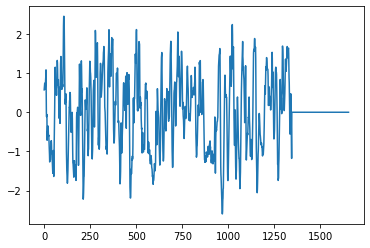

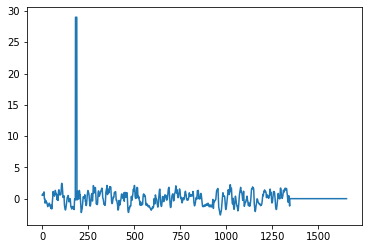

In [21]:
# Test data augmentations

i, t = next(dl)
t2 = transforms(t[0], mask_value=EOS_TOKEN)
# len(t)
print("Shapes:", t[0].shape, t[1].shape, t[2].shape, t[3].shape)
# print("Shapes:", t2[0].shape, t2[1].shape, t2[2].shape, t2[3].shape)

# # Plot data augmentation
y = t[0][0, :, 1]
x = [i for i in range(len(y))]

plt.plot(x, y)
plt.show()

# Plot non-augmented data
y = t2[0, :, 1]
x = [i for i in range(len(y))]

plt.plot(x, y)
plt.show()


# Model

In this section you will be building the LAS model from scratch. Before starting to code, please read the writeup, paper and understand the following parts completely.<br>
- Pyramidal Bi-LSTM 
- Listener
- Attention
- Speller

After getting a good grasp of the workings of these modules, start coding. Follow the TODOs carefully. We will also be adding some extra features to the attention mechanism like keys and values which are not originally present in LAS. So we will be creating a hybrid network based on LAS and Attention is All You Need.


## Encoder

In [22]:
# https://pytorchnlp.readthedocs.io/en/latest/_modules/torchnlp/nn/lock_dropout.html
class LockedDropout(torch.nn.Module):
    def __init__(self, p):
        self.p = p
        super().__init__()
    def forward(self, x, disable=False):
        if not self.training or self.p == 0 or disable:
            return x
        x, x_lens = pad_packed_sequence(x, batch_first=True)
        x = x.clone()
        mask = x.new_empty(x.size(0), 1, x.size(2), requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        mask = mask.expand_as(x)
        x = x * mask
        x = pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
        return x

### Pyramidal Bi-LSTM

In [23]:
class pBLSTM(torch.nn.Module):

    '''
    Pyramidal BiLSTM
    Read the write up/paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed (Unpack it)
    2. Reduce the input length dimension by concatenating feature dimension
        (Tip: Write down the shapes and understand)
        (i) How should  you deal with odd/even length input? 
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''
    
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        self.blstm = torch.nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, bidirectional=True)

        
        # TODO: Initialize a single layer bidirectional LSTM with the given input_size and hidden_size

    def forward(self, x_packed): # x_packed is a PackedSequence

        # TODO: Pad Packed Sequence
        
        # Call self.trunc_reshape() which downsamples the time steps of x and increases the feature dimensions as mentioned above
        # self.trunc_reshape will return 2 outputs. What are they? Think about what quantites are changing.
        # TODO: Pack Padded Sequence. What output(s) would you get?
        # TODO: Pass the sequence through bLSTM

        # What do you return?

        x_packed, x_lens = pad_packed_sequence(x_packed, batch_first=True)

        reshaped_x, re_x_lens = self.trunc_reshape(x_packed, x_lens)

        packed_x = pack_padded_sequence(reshaped_x, re_x_lens, batch_first=True, enforce_sorted=False)

        result, h = self.blstm(packed_x)

        return result

    def trunc_reshape(self, x, x_lens): 
        # TODO: If you have odd number of timesteps, how can you handle it? (Hint: You can exclude them)
        # TODO: Reshape x. When reshaping x, you have to reduce number of timesteps by a downsampling factor while increasing number of features by the same factor
        # TODO: Reduce lengths by the same downsampling factor

        x_lens //= 2

        x = x[:, :x.shape[1] - x.shape[1] % 2, :]
        x = x.reshape((x.shape[0], x.shape[1] // 2, 2 * x.shape[2]))

        return x, x_lens

### Listener

In [24]:
class Listener(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size):
        super(Listener, self).__init__()

        # The first LSTM at the very bottom
        self.base_lstm = torch.nn.LSTM(input_size, encoder_hidden_size, batch_first=True, bidirectional=True, num_layers=1)#TODO: Fill this up
        self.base_ld = LockedDropout(0.35)
        # self.pBLSTMs = torch.nn.Sequential( # How many pBLSTMs are required?
            # TODO: Fill this up with pBLSTMs - What should the input_size be? 
            # Hint: You are downsampling timesteps by a factor of 2, upsampling features by a factor of 2 and the LSTM is bidirectional)
            # Optional: Dropout/Locked Dropout after each pBLSTM (Not needed for early submission)
            # ...
            # ...
        self.pBLSTM1 = pBLSTM(encoder_hidden_size*4, encoder_hidden_size)
        self.ld1 = LockedDropout(0.35)
        self.pBLSTM2 = pBLSTM(encoder_hidden_size*4, encoder_hidden_size)
        self.ld2 = LockedDropout(0.35)
        self.pBLSTM3 = pBLSTM(encoder_hidden_size*4, encoder_hidden_size)
        self.ld3 = LockedDropout(0.35)

        self.ldpBLSTMs = torch.nn.Sequential(self.base_ld,
                                             self.pBLSTM1,
                                             self.ld1,
                                             self.pBLSTM2,
                                             self.ld2,
                                             self.pBLSTM3,
                                             self.ld3)
        
        self.pBLSTMs = torch.nn.Sequential(self.pBLSTM1,
                                           self.pBLSTM2,
                                           self.pBLSTM3)
        # )
         
    def forward(self, x, x_lens, disable_dropout=False):
        # Where are x and x_lens coming from? The dataloader
        
        # TODO: Pack Padded Sequence
        # TODO: Pass it through the first LSTM layer (no truncation)
        # TODO: Pad Packed Sequence
        # TODO: Pass Sequence through the pyramidal Bi-LSTM layer

        # Remember the number of output(s) each function returns

        packed_x = pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
        
        # x1, h = self.base_lstm(packed_x)
        # x2 = self.pBLSTMs(x1)
        x, h = self.base_lstm(packed_x)
        x = self.base_ld(x, disable_dropout)

        # packed_x = pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)

        x = self.pBLSTM1(x)
        x = self.ld1(x, disable_dropout)

        # packed_x = pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)

        x = self.pBLSTM2(x)
        x = self.ld2(x, disable_dropout)

        # packed_x = pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)

        x = self.pBLSTM3(x)
        x = self.ld3(x, disable_dropout)


        encoder_outputs, encoder_lens = pad_packed_sequence(x, batch_first=True)

        return encoder_outputs, encoder_lens

In [25]:
# example_batch = torch.Tensor(X_train)
# example_batch.shape
# example_batch

In [26]:
# input = np.zeros((BATCH_SIZE, 1000, 1000))
# lens = np.ones((BATCH_SIZE)) * 1000

In [27]:
# toy_data = ToyDataset("train")
# toy_dataloader = torch.utils.data.DataLoader(toy_data, num_workers= 2,
#                                            batch_size=BATCH_SIZE, pin_memory= True,
#                                            shuffle= True, collate_fn= toy_data.collate_fn)
# example_dataloader = enumerate(toy_dataloader)
# i, example_data = next(example_dataloader)

In [28]:
# toy_data_val = ToyDataset("valid")
# toy_dataloader_val = torch.utils.data.DataLoader(toy_data_val, num_workers= 2,
#                                            batch_size=BATCH_SIZE, pin_memory= True,
#                                            shuffle= False, collate_fn= toy_data_val.collate_fn)

In [29]:


# encoder = Listener(input_size=15, encoder_hidden_size=128)
# # TODO: Initialize Listener
# print(encoder)
# summary(encoder, example_data[0], example_data[3])
# del encoder

## Attention (Attend)

### Different ways to compute Attention

1. Dot-product attention
    * raw_weights = bmm(key, query) 
    * Optional: Scaled dot-product by normalizing with sqrt key dimension 
    * Check "Attention is All You Need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore, check out other methods below


2. Cosine attention
    * raw_weights = cosine(query, key) # almost the same as dot-product xD 

3. Bi-linear attention
    * W = Linear transformation (learnable parameter): d_k -> d_q
    * raw_weights = bmm(key @ W, query)

4. Multi-layer perceptron
    * Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4

5. Multi-Head Attention
    * Check "Attention is All You Need" Section 3.2.2
    * h = Number of heads
    * W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
    * W_O: d_v -> d_v
    * Reshape K: (B, T, d_k) to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
    * Reshape V: (B, T, d_v) to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
    * Reshape Q: (B, d_q) to (B, h, d_q // h) `
    * raw_weights = Q @ K^T
    * masked_raw_weights = mask(raw_weights)
    * attention = softmax(masked_raw_weights)
    * multi_head = attention @ V
    * multi_head = multi_head reshaped to (B, d_v)
    * context = multi_head @ W_O

In [30]:
def plot_attention(attention): 
    # Function for plotting attention
    # You need to get a diagonal plot
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

class Attention(torch.nn.Module):
    '''
    Attention is calculated using the key, value (from encoder hidden states) and query from decoder.
    Here are different ways to compute attention and context:

    After obtaining the raw weights, compute and return attention weights and context as follows.:

    masked_raw_weights  = mask(raw_weights) # mask out padded elements with big negative number (e.g. -1e9 or -inf in FP16)
    attention           = softmax(masked_raw_weights)
    context             = bmm(attention, value)
    
    At the end, you can pass context through a linear layer too.

    '''
    
    def __init__(self, encoder_hidden_size, decoder_output_size, projection_size):
        super(Attention, self).__init__()

        self.key_projection     = torch.nn.Linear(encoder_hidden_size*2, projection_size) # TODO: Define an nn.Linear layer which projects the encoder_hidden_state to keys
        self.value_projection   = torch.nn.Linear(encoder_hidden_size*2, projection_size) # TODO: Define an nn.Linear layer which projects the encoder_hidden_state to value
        self.query_projection   = torch.nn.Linear(decoder_output_size, projection_size) # TODO: Define an nn.Linear layer which projects the decoder_output_state to query
        # Optional : Define an nn.Linear layer which projects the context vector

        self.softmax            = torch.nn.Softmax(dim=1) # TODO: Define a softmax layer. Think about the dimension which you need to apply 
        # Tip: What is the shape of energy? And what are those?
        self.projection_size = projection_size

    # As you know, in the attention mechanism, the key, value and mask are calculated only once.
    # This function is used to calculate them and set them to self
    def set_key_value_mask(self, encoder_outputs, encoder_lens):
    
        _, encoder_max_seq_len, _ = encoder_outputs.shape

        self.key      = self.key_projection(encoder_outputs) # TODO: Project encoder_outputs using key_projection to get keys
        self.value    = self.value_projection(encoder_outputs) # TODO: Project encoder_outputs using value_projection to get values

        # encoder_max_seq_len is of shape (batch_size, ) which consists of the lengths encoder output sequences in that batch
        # The raw_weights are of shape (batch_size, timesteps)

        # TODO: To remove the influence of padding in the raw_weights, we want to create a boolean mask of shape (batch_size, timesteps) 
        # The mask is False for all indicies before padding begins, True for all indices after.
        self.padding_mask     =  torch.arange(encoder_max_seq_len).unsqueeze(0) >= encoder_lens.unsqueeze(1) # TODO: You want to use a comparison between encoder_max_seq_len and encoder_lens to create this mask. 
        # import IPython
        # IPython.embed()
        self.padding_mask     =  self.padding_mask.to(DEVICE)
        # (Hint: Broadcasting gives you a one liner)
        
    def forward(self, decoder_output_embedding):
        # key   : (batch_size, timesteps, projection_size)
        # value : (batch_size, timesteps, projection_size)
        # query : (batch_size, projection_size)

        self.query         = self.query_projection(decoder_output_embedding) # TODO: Project the query using query_projection

        # Hint: Take a look at torch.bmm for the products below 
        raw_weights        = torch.bmm(self.key, self.query.unsqueeze(2)).squeeze(2) # TODO: Calculate raw_weights which is the product of query and key, and is of shape (batch_size, timesteps)
        masked_raw_weights = raw_weights.masked_fill_(self.padding_mask, -float('inf'))# TODO: Mask the raw_weights with self.padding_mask. 
        # Take a look at pytorch's masked_fill_ function (You want the fill value to be a big negative number for the softmax to make it close to 0)

        attention_weights  = self.softmax(masked_raw_weights) # TODO: Calculate the attention weights, which is the softmax of raw_weights
        context            = torch.bmm(attention_weights.unsqueeze(1), self.value).squeeze(1) # TODO: Calculate the context - it is a product between attention_weights and value

        # Hint: You might need to use squeeze/unsqueeze to make sure that your operations work with bmm

        return context, attention_weights # Return the context, attention_weights

## Decoder

### Speller

In [31]:
class Speller(torch.nn.Module):

    def __init__(self, embed_size, decoder_hidden_size, decoder_output_size, vocab_size, attention_module= None):
        super().__init__()

        self.vocab_size         = vocab_size

        self.embedding          = torch.nn.Embedding(vocab_size, embed_size, padding_idx=EOS_TOKEN) # TODO: Initialize the Embedding Layer (Use the nn.Embedding Layer from torch), make sure you set the correct padding_idx  

        self.lstm_cells         = torch.nn.Sequential(
                                    torch.nn.LSTMCell(embed_size + decoder_output_size, decoder_hidden_size),
                                    torch.nn.LSTMCell(decoder_hidden_size, decoder_hidden_size),
                                    torch.nn.LSTMCell(decoder_hidden_size, decoder_output_size)
                                # Create Two LSTM Cells as per LAS Architecture
                                # What should the input_size of the first LSTM Cell? 
                                # Hint: It takes in a combination of the character embedding and context from attention
                                )
    
                                # We are using LSTMCells because process individual time steps inputs and not the whole sequence.
                                # Think why we need this in terms of the query

        self.char_prob          = torch.nn.Linear(attention_module.projection_size + decoder_output_size, vocab_size) # TODO: Initialize the classification layer to generate your probability distribution over all characters

        self.char_prob.weight   = self.embedding.weight # Weight tying

        self.attention          = attention_module

    
    def forward(self, encoder_outputs, encoder_lens, y = None, tf_rate = 1): 

        '''
        Args: 
            embedding: Attention embeddings 
            hidden_list: List of Hidden States for the LSTM Cells
        ''' 

        batch_size, encoder_max_seq_len, _ = encoder_outputs.shape

        if self.training:
            timesteps     = y.shape[1] # The number of timesteps is the sequence of length of your transcript during training
            label_embed   = self.embedding(y) # Embeddings of the transcript, when we want to use teacher forcing
        else:
            timesteps     = 600 # 600 is a design choice that we recommend, however you are free to experiment.
        

        # INITS
        predictions     = []

        # Initialize the first character input to your decoder, SOS
        char            = torch.full((batch_size,), fill_value=SOS_TOKEN, dtype= torch.long).to(DEVICE) 

        # Initialize a list to keep track of LSTM Cell Hidden and Cell Memory States, to None
        hidden_states   = [None]*3 

        attention_plot          = []
        context                 = torch.zeros(batch_size, self.attention.projection_size).to(DEVICE) # TODO: Initialize context (You have a few choices, refer to the writeup )
        attention_weights       = torch.zeros(batch_size, encoder_max_seq_len) # Attention Weights are zero if not using Attend Module

        # Set Attention Key, Value, Padding Mask just once
        if self.attention != None:
            self.attention.set_key_value_mask(encoder_outputs, encoder_lens)


        for t in range(timesteps):
            
            # TODO: Generate the embedding for the character at timestep t
            char_embed = self.embedding(char)

            if self.training and t > 0:
                # TODO: We want to decide which embedding to use as input for the decoder during training
                # We can use the embedding of the transcript character or the embedding of decoded/predicted character, from the previous timestep 
                # Using the embedding of the transcript character is teacher forcing, it is very important for faster convergence
                # Use a comparison between a random probability and your teacher forcing rate, to decide which embedding to use
                if np.random.random() < tf_rate:
                  char_embed = label_embed[:, t-1, :]

            # TODO: What do we want to concatenate as input to the decoder? (Use torch.cat)
            decoder_input_embedding = torch.cat([char_embed, context], dim=1)
            
            # Loop over your lstm cells
            # Each lstm cell takes in an embedding 
            for i in range(len(self.lstm_cells)):
                # An LSTM Cell returns (h,c) -> h = hidden state, c = cell memory state
                # Using 2 LSTM Cells is akin to a 2 layer LSTM looped through t timesteps 
                # The second LSTM Cell takes in the output hidden state of the first LSTM Cell (from the current timestep) as Input, along with the hidden and cell states of the cell from the previous timestep
                hidden_states[i] = self.lstm_cells[i](decoder_input_embedding, hidden_states[i]) 
                decoder_input_embedding = hidden_states[i][0]

            # The output embedding from the decoder is the hidden state of the last LSTM Cell
            decoder_output_embedding = hidden_states[-1][0]

            # We compute attention from the output of the last LSTM Cell
            if self.attention != None:
                context, attention_weights = self.attention(decoder_output_embedding) # The returned query is the projected query

            attention_plot.append(attention_weights[0].detach().cpu())

            output_embedding     = torch.cat([self.attention.query, context], dim=1)# TODO: Concatenate the projected query with context for the output embedding
            # Hint: How can you get the projected query from attention
            # If you are not using attention, what will you use instead of query?
            
            char_prob            = self.char_prob(output_embedding)
            
            # Append the character probability distribution to the list of predictions 
            predictions.append(char_prob)

            char = torch.argmax(char_prob, dim=1)# TODO: Get the predicted character for the next timestep from the probability distribution 
            # (Hint: Use Greedy Decoding for starters)

        attention_plot  = torch.stack(attention_plot, dim=0) # TODO: Stack list of attetion_plots 
        predictions     = torch.stack(predictions, dim=1)# TODO: Stack list of predictions 

        return predictions, attention_plot

## Sequence-to-Sequence Model

### LAS

In [32]:
class LAS(torch.nn.Module):
    def __init__(self, input_size, encoder_hidden_size, 
                 vocab_size, embed_size,
                 decoder_hidden_size, decoder_output_size,
                 projection_size= 128):
        
        super(LAS, self).__init__()

        self.encoder        = Listener(input_size, encoder_hidden_size) # TODO: Initialize Encoder
        attention_module    = Attention(encoder_hidden_size, decoder_output_size, projection_size) # TODO: Initialize Attention
        self.decoder        = Speller(embed_size, decoder_hidden_size, decoder_output_size, vocab_size, attention_module) # TODO: Initialize Decoder, make sure you pass the attention module 

    def forward(self, x, x_lens, y = None, tf_rate = 1):

        encoder_outputs, encoder_lens = self.encoder(x, x_lens, disable_dropout=tf_rate==1) # from Listener
        predictions, attention_plot = self.decoder(encoder_outputs, encoder_lens, y, tf_rate)
        
        return predictions, attention_plot

# Training Setup

## Model Setup










In [33]:
# example_data[1].shape

In [34]:
# example_data[0].shape

In [35]:
# torch.LongTensor(example_data[3])

In [36]:
# 30
# np.unique(X_train)

In [37]:
# Baseline LAS has the following configuration:
# Encoder bLSTM/pbLSTM Hidden Dimension of 512 (256 per direction)
# Decoder Embedding Layer Dimension of 256
# Decoder Hidden Dimension of 512 
# Decoder Output Dimension of 128
# Attention Projection Size of 128
# Feel Free to Experiment with this 

input_size = 15
encoder_hidden_size = 512
vocab_size = len(VOCAB)
embed_size = 256
decoder_hidden_size = 512
decoder_output_size = 128
projection_size = 128

model = LAS(
    input_size, 
    encoder_hidden_size, 
    vocab_size, 
    embed_size,
    decoder_hidden_size, 
    decoder_output_size,
    projection_size
    # Initialize your model 
    # Read the paper and think about what dimensions should be used
    # You can experiment on these as well, but they are not requried for the early submission
    # Remember that if you are using weight tying, some sizes need to be the same
)

model = model.to(DEVICE)
# x = example_data[0].to(DEVICE)
# y = example_data[1].to(DEVICE)
# print(model)

# summary(model, 
#         x= x, 
#         x_lens= example_data[3], 
#         y= y)

## Optimizer, Scheduler, Loss

In [38]:
optimizer   = torch.optim.Adam(model.parameters(), lr= config['lr'], amsgrad= True, weight_decay= 5e-6)
criterion   = torch.nn.CrossEntropyLoss(reduction='none') # Why are we using reduction = 'none' ? 
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True)
# Optional: Create a custom class for a Teacher Force Schedule 
# tf_rate_scheduler = np.zeros(200)
# tf_rate_scheduler[0:30] = 1
# tf_rate_scheduler[30:70] = np.linspace(1, 0, 40)
# tf_rate_scheduler[70:] = 0

tf_rate_scheduler = np.zeros(200)
tf_rate_scheduler[0:30] = 1
tf_rate_scheduler[30:50] = np.linspace(1, 0.5, 20)
tf_rate_scheduler[50:60] = 0.5
tf_rate_scheduler[60:80] = np.linspace(0.5, 0.25, 20)
tf_rate_scheduler[80:90] = 0.25
tf_rate_scheduler[90:190] = np.linspace(0.25, 0, 100)
tf_rate_scheduler[190:] = 0

# Levenshtein Distance

In [39]:
# We have given you this utility function which takes a sequence of indices and converts them to a list of characters
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if vocab[int(i)] == vocab[SOS_TOKEN]: # If SOS is encountered, dont add it to the final list
            continue
        elif vocab[int(i)] == vocab[EOS_TOKEN]: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])
    return tokens

# To make your life more easier, we have given the Levenshtein distantce / Edit distance calculation code
def calc_edit_distance(predictions, y, ly, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size): 

        y_sliced    = indices_to_chars(y[batch_idx,0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        
        dist        += Levenshtein.distance(pred_string, y_string)
        # Comment the above abd uncomment below for toy dataset 
        # dist      += Levenshtein.distance(y_sliced, pred_sliced)

    if print_example: 
        # Print y_sliced and pred_sliced if you are using the toy dataset
        print("Ground Truth : ", y_string)
        print("Prediction   : ", pred_string)
        
    dist/=batch_size
    return dist

# Train and Evaluate

In [40]:
def train(model, dataloader, criterion, optimizer, teacher_forcing_rate, aug_data=False):

    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    running_perplexity  = 0.0
    
    for i, (x, y, lx, ly) in enumerate(dataloader):

        optimizer.zero_grad()

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.cuda.amp.autocast():

            if aug_data:
                x = transforms(x, mask_value=0)

            predictions, attention_plot = model(x, lx, y= y, tf_rate= teacher_forcing_rate)

            # Predictions are of Shape (batch_size, timesteps, vocab_size). 
            # Transcripts are of shape (batch_size, timesteps) Which means that you have batch_size amount of batches with timestep number of tokens.
            # So in total, you have batch_size*timesteps amount of characters.
            # Similarly, in predictions, you have batch_size*timesteps amount of probability distributions.
            # How do you need to modify transcipts and predictions so that you can calculate the CrossEntropyLoss? Hint: Use Reshape/View and read the docs
            
            
            # y_onehot    = torch.nn.functional.one_hot(y, num_classes=len(VOCAB))
            # predictions_reshaped = predictions.permute((0, 2, 1))
            # prediction_amax = torch.argmax(predictions_reshaped, dim=1)

            loss        =  criterion(predictions.view(-1, predictions.shape[2]), y.view(-1)) # TODO: Cross Entropy Loss

            # mask        = torch.cat([torch.range(start = 0, end=lx[i]) <= ly[i] for i in lx.shape[0]], 0)
            mask       =  (torch.arange(y.shape[1]).squeeze(0) < ly.unsqueeze(1)).to(DEVICE)
            # TODO: Create a boolean mask using the lengths of your transcript that remove the influence of padding indices (in transcripts) in the loss 
            masked_loss = ((loss * mask.view(-1)).sum() / mask.sum())
            # masked_loss = loss
            # Product between the mask and the loss, divided by the mask's sum. Hint: You may want to reshape the mask too 
            perplexity  = torch.exp(masked_loss) # Perplexity is defined the exponential of the loss

            running_loss        += masked_loss.item()
            running_perplexity  += perplexity.item()
        
        # Backward on the masked loss
        scaler.scale(masked_loss).backward()

        # Optional: Use torch.nn.utils.clip_grad_norm to clip gradients to prevent them from exploding, if necessary
        # If using with mixed precision, unscale the Optimizer First before doing gradient clipping
        
        scaler.step(optimizer)
        scaler.update()
        

        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(teacher_forcing_rate))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot

In [41]:
def validate(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.inference_mode():
            predictions, attentions = model(x, lx, y = None)

        # Greedy Decoding
        greedy_predictions   =  torch.argmax(predictions, dim=-1)
        # TODO: How do you get the most likely character from each distribution in the batch?
        # print([VOCAB[x] for x in greedy_predictions[0]])

        # Calculate Levenshtein Distance
        running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = True) # You can use print_example = True for one specific index i in your batches if you want

        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist/(i+1)))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    batch_bar.close()
    running_lev_dist /= len(dataloader)

    return running_lev_dist#, running_loss, running_perplexity, 

In [42]:
# validate(model, train_loader)

# Wandb

In [43]:
run_name = "LAS004"

In [44]:
# Login to Wandb
# Initialize your Wandb Run Here
# Optional: Save your model architecture in a txt file, and save the file to Wandb
import wandb
wandb.login(key="a8b39d27e28590586b7efa4abb3acaad4e91b958") #API Key is in your wandb account, under settings (wandb.ai/settings)
# Create your wandb run
run = wandb.init(
    name = run_name, ### Wandb creates random run names if you skip this field, we recommend you give useful names
    reinit=True, ### Allows reinitalizing runs when you re-run this cell
    project="hw4p2", ### Project should be created in your wandb account 
    config=config ### Wandb Config for your run
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: akh. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [45]:
### Save your model architecture as a string with str(model) 
model_arch = str(model)

### Save it in a txt file 
arch_file = open("model_arch.txt", "w")
file_write = arch_file.write(model_arch)
arch_file.close()

### log it in your wandb run with wandb.save()
wandb.save('model_arch.txt')

['/content/wandb/run-20221212_001626-1toe4pgm/files/model_arch.txt']

# Experiments


Epoch: 1/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:584.)


Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  AND THE STREET OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  AND THE STREET OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE

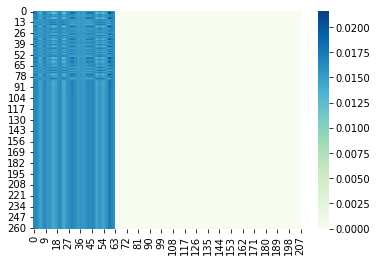

Save successful 0

Epoch: 2/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  AND THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STR
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  AND THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE STREET OF THE

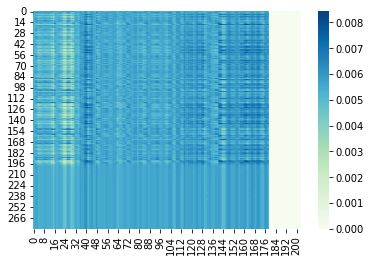

Train:   0%|          | 0/298 [00:00<?, ?it/s]


Epoch: 3/200


Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  AND THE STREET WAS A STRANGER AND THE STREET WHICH HE HAD BEEN SO STRUCK THE STREET WHICH HE HAD BEEN SO STRUCK THE STREET WHICH HE HAD BEEN SO STRUCK THE STREET WHICH HE HAD BEEN SO STRUCK THE STREET WHICH HE HAD BEEN SO STRUCK THE STREET WHICH HE HAD BEEN SO STRUCK THE STREET WHICH HE HAD BEEN SO STRUCK THE STREET WHICH HE HAD BEEN SO STRUCK THE STREET WHICH HE HAD BEEN SO STRUCK THE STREET WHICH HE HAD BEEN SO STRUCK THE STREET WHICH HE HAD BEEN SO STRUCK THE STREET WHICH HE HAD BEEN SO STRUCK THE STREET WHICH HE HAD BEEN SO STRUCK THE STREET WHICH HE HAD BEEN SO STRUCK THE STREET WHICH HE
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  AND THE STREET WAS A STRANGER OF THE STREET WHICH HE HAD BEEN SO MUCH AS I HAD A STRANGER OF THE STREET W

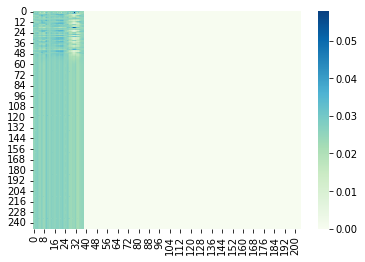


Epoch: 4/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  AND THE STRANGER WAS A CONSIDERABLE PROPERTY OF THE STREET AND THE STRANGER WAS A CONSIDERABLE PROPERTY OF THE STREET AND THE STRANGER WAS A CONSIDERABLE PROPERTY OF THE STREET AND THE STRANGER WAS A CONSIDERABLE PROPERTY OF THE STREET AND THE STRANGER WAS A CONSIDERABLE PROPERTY OF THE STREET AND THE STRANGER WAS A CONSIDERABLE PROPERTY OF THE STREET AND THE STRANGER WAS A CONSIDERABLE PROPERTY OF THE STREET AND THE STRANGER WAS A CONSIDERABLE PROPERTY OF THE STREET AND THE STRANGER WAS A CONSIDERABLE PROPERTY OF THE STREET AND THE STRANGER WAS A CONSIDERABLE PROPERTY OF THE STREET AND THE S
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  AND THE STRANGER WAS A CONSIDERABLE PROPERTY OF THE STREET AND THE STRANGER WAS A CONSIDERABLE PROPERTY O

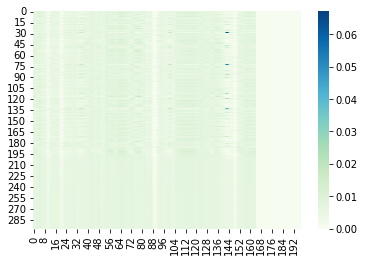


Epoch: 5/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS THE STREET AND THE STREET WAS 

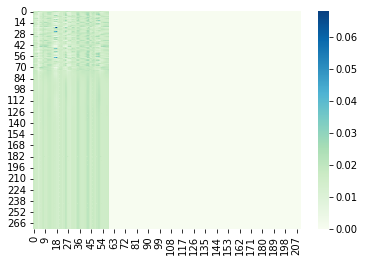


Epoch: 6/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  AND THE SUN WAS A STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND SO THAT THE SUN WAS A STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND SO THAT THE SUN WAS A STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE A
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  AND THE SUN WAS A STRANGE AND STRANGE AND STRANGE AND STRANGE AND THE SUN WAS A STRANGE AND STRANGE AND S

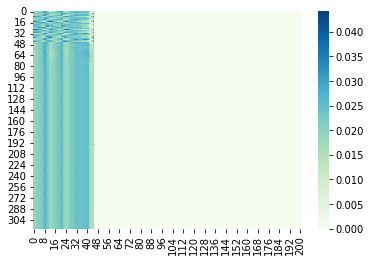

Save successful 5

Epoch: 7/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  AND THE STRANGE FACE WAS A STRANGE AND THE STRANGE FACE OF THE STREET THE STRANGE FACE WAS A STRANGE AND THE STRANGE FACE OF THE STREET THE STRANGE FACE WAS A STRANGE AND THE STRANGE FACE OF THE STREET THE STRANGE FACE WAS A STRANGE AND THE STRANGE FACE OF THE STREET THE STRANGE FACE WAS A STRANGE AND THE STRANGE FACE OF THE STREET THE STRANGE FACE WAS A STRANGE AND THE STRANGE FACE OF THE STREET THE STRANGE FACE WAS A STRANGE AND THE STRANGE FACE OF THE STREET THE STRANGE FACE WAS A STRANGE AND THE STRANGE FACE OF THE STREET THE STRANGE FACE WAS A STRANGE AND THE STRANGE FACE OF THE STREET T
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  AND THE STRANGE FACE WAS A STRANGE AND THE STRANGE FACE OF THE STREETS AND THE STRANGE FACES OF THE STREE

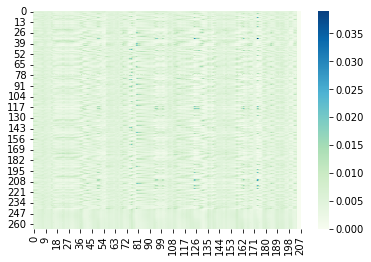


Epoch: 8/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A 
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE STRANGER WAS A STRANGER AND THE S

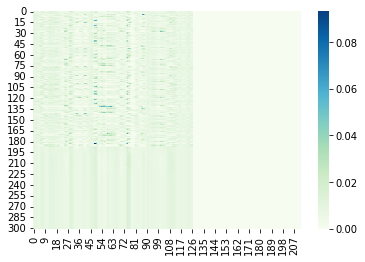


Epoch: 9/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  AND THE STARS HAD BEEN A STRANGER AND THE SERVANT OF THE STAR AND THE STARS AND THE STARS AND THE STERN STARS AND THE STERN STARS AND THE STERN STARRY STERN STARRING AND THE STARS HAD BEEN A STRANGE STAR AND THE STARS HAD BEEN A STRANGE STAR AND THE STARS HAD BEEN A STRANGE STAR AND THE STARS HAD BEEN A STRANGE STAR AND THE STARS HAD BEEN A STRANGE STAR AND THE STARS HAD BEEN A STRANGE STAR AND THE STARS HAD BEEN A STRANGE STAR AND THE STARS HAD BEEN A STRANGE STAR AND THE STARS HAD BEEN A STRANGE STAR AND THE STARS HAD BEEN A STRANGE STAR AND THE STARS HAD BEEN A STRANGE STAR AND THE STARS H
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  AND THE STRANGER WAS A STRANGER TO THE STRENGTH OF THE STREAM THE STREAM WAS A BRIGHT STREAM OF THE STREE

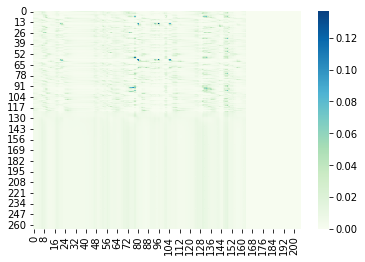


Epoch: 10/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  AND HE HAD A GREAT DEAL OF HIS SUSPICION
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE MAN WAS A GREAT MAN OF THE MOUNTAINS AND THE SUN WAS A BROAD BROWN BOAT AND THE STREETS OF THE BROAD BROWN BOAT AND THE STREETS OF THE BROAD BROWN BOAT AND THE STREETS OF THE BROAD BROWN BOAT AND THE STREETS OF THE BROAD BROWN BOAT AND THE STREETS OF THE BROAD BROWN BOAT AND THE STREETS OF THE BROAD BROWN BOAT AND THE STREETS OF THE BROAD BROWN BOAT AND THE STREETS OF THE BROAD BROWN BOAT AND THE STREETS OF THE BROAD BROWN BOAT AND THE STREETS OF THE BROAD BROWN BOAT AND THE STREETS OF THE BROAD BROWN BOAT AND THE STREETS OF THE BROAD BROWN BOAT AND THE STREETS OF THE BROAD BROWN BOAT AND
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMA

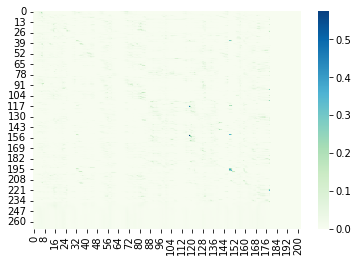


Epoch: 11/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD IN PRAVED AND SISTER IN THE EVENT THAT WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEGRAPHLY WAS SO REPAIRED AND A STEADY STREET OF REFERENCE THE REAL BEAUTIERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLTER OF HOWEVER ISLES THE STINGED TO LEGITIMATE RENEWARD OF A MOVEMENT AT THE REMERARD IN ARE ACCOMPANIES
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE PORING WOVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAID SIR HARD THE LILDERS GOING FAINTIVE IN THE GIBBETHONY
Ground Truth :  UNDER THE TUITION OF THE ABBOT SE

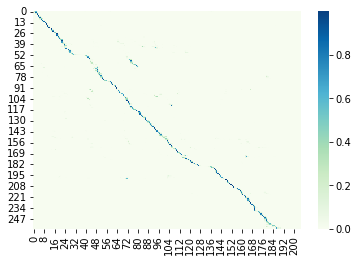

Save successful 10

Epoch: 12/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SO REPAIRED AND A STATEY STREAM OF RESCUING BY A CARNECLES FIRE TRUNKS THREE ABUNDANCES AND PRIVATE CARS DRIVEN BY VALIANT TEARS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLT BROW HOWEVER HIS LESS DISTINCTIVELY GENERANT AS THE GREATER NUMBER OF ITS TATERANS ARE ANNARIOUS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE CAUSED A RED FACE POINT OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING FAMISHED TO 

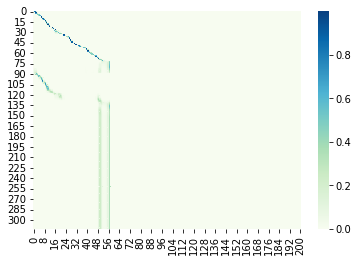


Epoch: 13/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEGRAM WAS SOON REPAIRED AND A STEADY STREEM OF RESCUE VIEWLESS BEGIN ARRIVING FROM HARNESS FIRE TRUTHS THREE ABYUNDS IS AND PRIVATE CARS DRIVEN BY VALIN TEARS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLT BROW HOWEVER IS LESS DISTINCTIVELY JURIA AS THE GREATER NUMBER OF IT TATROOMS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE CAN'T A RED FACE POINT OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HERE THE LITTLE GIRL'S GOING FAM

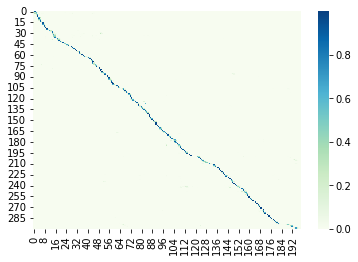


Epoch: 14/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHOLOGINE WAS SOON REPAIRED AND A STEAM OF REFUGE VIEWN ARIVING FROM HEARTNESS FIRE TRUCKS THREE ABLESS BEGAN A RIVING FROM HEARTNESS FIRE TRUCKS THREE AMBIOUS AS AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLT BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS TATERAMS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE CAN'T SAW RED FACE POINT OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction  

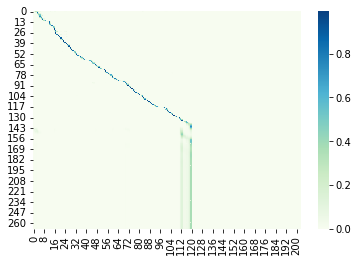


Epoch: 15/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROUGHT HER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCARS DRIVEN BY VALNESCENS AND PRIVATE CARS DRIVEN BY VALNET TEARS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLT BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS TATERANCE
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE CATCH'S A RED FACE POINT OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRL GOING FAMISHED LET NIGHT IT ISN'T SHE
Ground Truth :

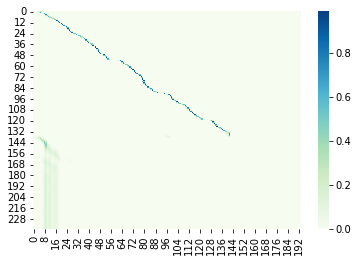


Epoch: 16/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF REFUGUINACLES BEGAN ARRIVING FROM HARNESS FIRE TRUCKS THREE ABUNCHES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHROGRAL HOWEVER HAS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS TATRARINS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINT OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SAID HARRY THE LITTLE GIRL'S GO

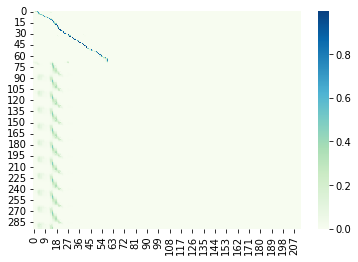

Save successful 15

Epoch: 17/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPEARED AND A STEADY STREAM OF RESCUIVATELLOWS BEGAN A RIVING FROM HARNESS FIRE TRUCKS THREE ABBUNCES AND PRIVATE CARS DRIVEN BY VALLEYNESS FIRE TRUCKS THREE ABBUNCES AND PRIVATE CARS DRIVEN BY VALLEYNESS FIRE TRUCKS THREE ABBUNCES AND PRIVATE CARS DRIVEN BY VALLEYNESS FIRE TRUCKS THREE ABBUNCES AND PRIVATE CARS DRIVEN BY VALLEYNESS FIRE TRUCKS THREE ABBUNCES AND PRIVATE CARS DRIVEN BY VALLEYNESS FIRE TRUCKS THREE ABBUNCES AND PRIVATE CARS DRIVEN BY VALLEYNESS FIRE TRUCKS THREE ABBUNCES AND PRIVATE CARS DRIVEN BY VALLEYNESS FIRE TRUCKS THREE ABBUNCES AND PRIVATE C
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DI

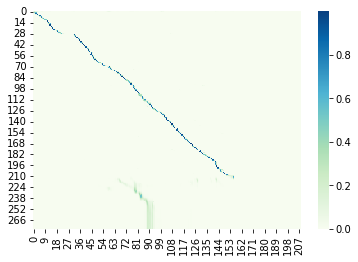


Epoch: 18/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  TELEPHOLE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUIVITICLES BEGAN A RIVING FROM HARANNESS FIRE TRUCKS THROUGH THREE ABBUINCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLT BROWN HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS TAPERANCE ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE PORING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SAID SIR HARRY THE LITT

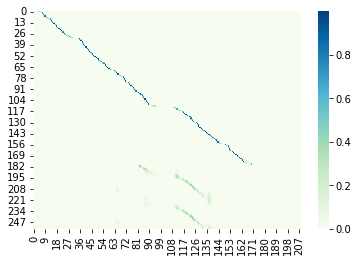


Epoch: 19/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROUGHT HER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUEVUICLES BEGIN ARRIVING FROM HARNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLT BROAD HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITALYTRANS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINT OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SAID HARRY THE LITTLE GIRLS GO

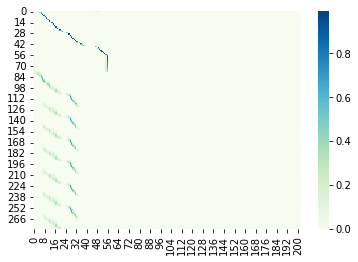


Epoch: 20/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROUGHT HER IN SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STATISTREAM OF RASCAL VEHICLES BEGAN A RIVING FROM HARNESS FIRE TRUCKS THREE ABLEANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLT BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS TATRORS ARE A EMERARICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINLING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE 

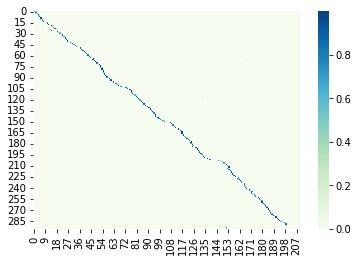


Epoch: 21/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AN SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE MINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN A RIVING FROM HARTNESS FIRE TREXTS THE REABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTARIES
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROARHOOD HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS TAPERANS OUR AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACED POINT OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIR

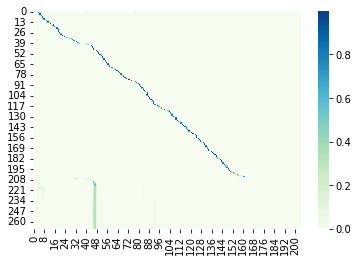

Save successful 20

Epoch: 22/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHOLE MIND WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN A RIVALING FROM HARTNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRUNK BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLT BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF THE TATRORS ARE AN ERRORKON
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SAID SHE SERVANT THE LI

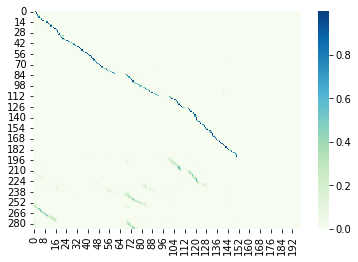


Epoch: 23/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BRETHREAR AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUINACLES BEGAN ARRIVING FROM HERKNESS FIRE TRUCKS THREE ABUNCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLT BROAD HOWEVER HIS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AN ERROR OF ITS PATRONS ARE AN ERROR OF ITS PATRONS ARE AN ERROR OF ITS PATRONS ARE AN ERROR OF ITS PATRONS ARE AN ERROR OF ITS PATRONS ARE AN ERROR OF ITS PATRONS ARE AN ERROR OF ITS PATRONS ARE AN ERROR OF ITS PATRONS ARE AN ERROR OF ITS PATRONS ARE

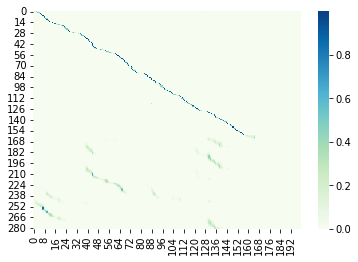


Epoch: 24/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHOLOGINE WAS SOON REPAIRED AN A STEADY STREAM OF REFUGE VEHICLES BEGAN ARRIVING FROM HARTNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOPE BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HURRIED THE LITTLE GIRL'

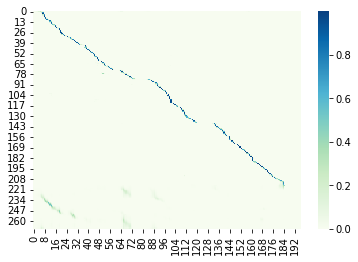


Epoch: 25/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEGONLINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN A RIVING FROM HARKNESS FIRE TRUCKS THREE ABBED AND SAID PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLK BROAD HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITALITERS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GO IN

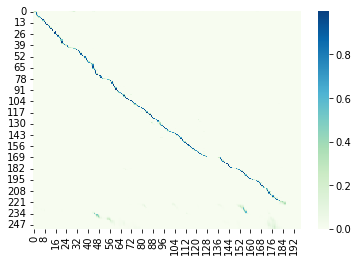


Epoch: 26/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABBEAUANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLK BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRIOTS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRIED THE LITTLE 

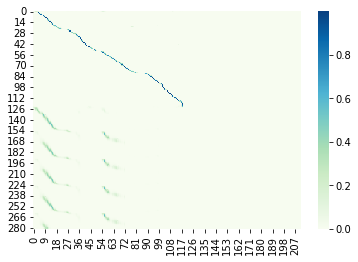

Save successful 25

Epoch: 27/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROUGHT HER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCULVIOUS BEGAN ARRIVING FROM HARTNESS FIRED TRUCKS THREE ABBUILENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLK BROAD HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF IT PATRONS ARE A MERICONS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINT OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SAID SIR HARRY THE LITTLE G

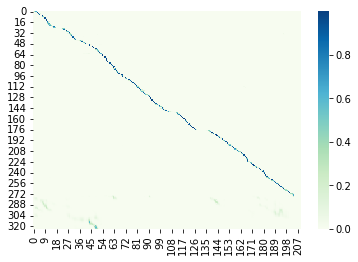


Epoch: 28/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF REFUGUE VIAGOS BEGAN ARRIVING FROM HARNESS FIRED TRUCKS THREE ABUNCES AND PRIVATE CARS DRIVEN BY VOLUMENTARIES
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOT BROAD HOWEVER HAS LESS DISTINCT OF LEAGUING AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS 

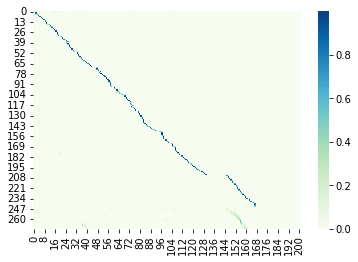


Epoch: 29/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCULVICLES BEGAN ARRIVING FROM HERKNESS FIRE TRUCKS THREE ABBUILANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLT BROAD HOWEVER IS LESS DISTINCTIVELY GERMIN AS THE GREATER NUMBER OF ITS PATRONS ARE AN ERRANTUMS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HERE THE LITTLE GIRLS

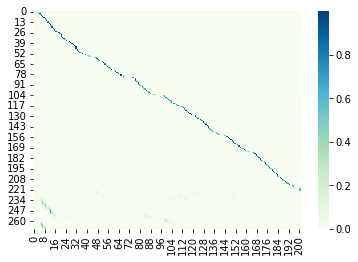


Epoch: 30/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCULVIEUALS BEGAN A RIVING FROM HARNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLT BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF IT PATRIOTS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACED POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HEARILY THE LITTLE GIRLS G

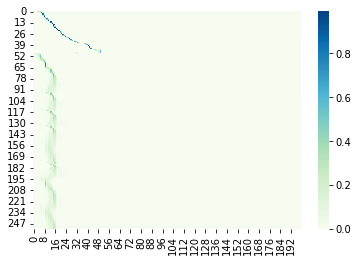


Epoch: 31/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCAL VEHICLES BEGAN ARRIVING FROM HARTNESS FIRE TRUCKS THREE ABUNCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOPE BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMING AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HERE THE LITTLE GIRL'S

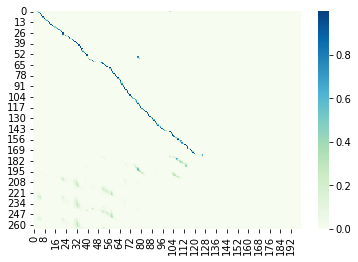

Save successful 30

Epoch: 32/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONEDLINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VIACLES BEGAN A RIVING FROM HARTON IS FIRED TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOT BROW HOEVER IS LESS DISTINCTLY GERMAN AS THE GREATER NUMBER OF IT TATRONS OUR AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING 

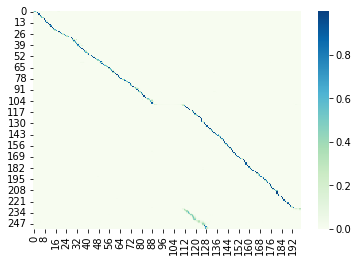


Epoch: 33/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELE OF ALL MINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUEVIUTCHES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULESCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTEL BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRIOTS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE G

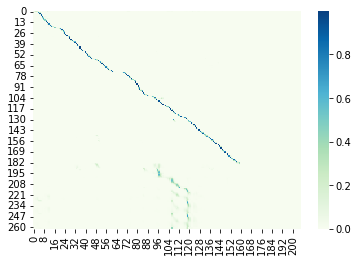


Epoch: 34/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKENESS FIRE TRUCKS THREE ABUNCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLT BROWN HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINLING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS G

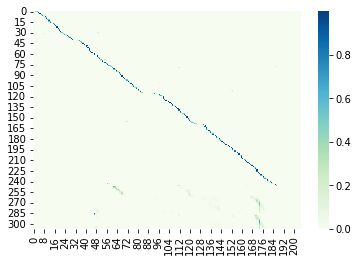


Epoch: 35/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VIAGO'S BEGAN A RIVING FROM HARNESS FIRE TRUCKS THREE ABBE ANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLTH BROWN HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRL'S

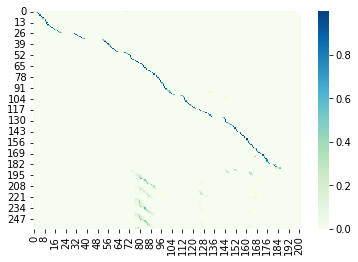


Epoch: 36/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VIAICLES BEGAN A RIVING FROM HARNESS FIRE TRUCKS THREE ABUNCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTEL BROAD HOWEVER IS LESS DISTINCTIVELY GERMING AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GO

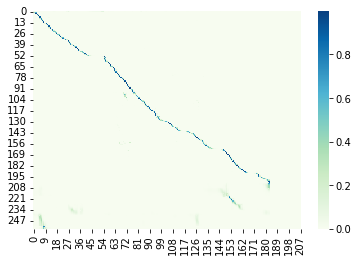

Save successful 35

Epoch: 37/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARNESS FIRE TRUCKS THREE ABBUINCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLT BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARAMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRIET THE LITTLE GIRLS GO

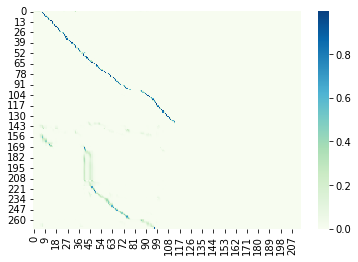


Epoch: 38/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN A RIVING FROM HARNESS FIRED TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLT BRAW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS G

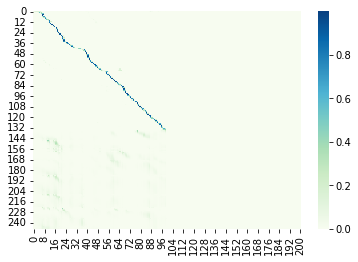


Epoch: 39/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VIEWLS BEGAN AWRIVING FROM HARNESS FIRE TRUCKS THREE ABBE ANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBROB HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GUESSED A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRL'S G

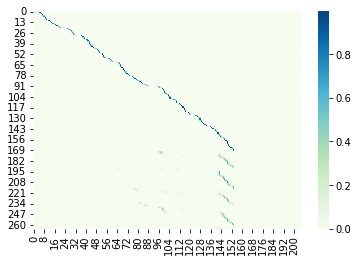


Epoch: 40/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VIACOAS BEGAN AWRIVING FROM HARNESS FIRED TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

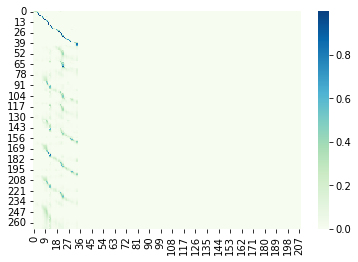


Epoch: 41/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCULVEIALS BEGAN A RIVING FROM HARKNESS FIRE TRUCKS THREE ABUENCES AND PRIVATE CARS DRIVEN BY VALETNEARS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHRILE HOWEVER IS LESS DISTINCTIVELY GERMING AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINT OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING FA

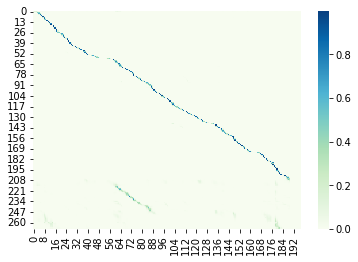

Save successful 40

Epoch: 42/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUEVIOCLES BEGAN AWRIVING FROM HARNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLT BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS G

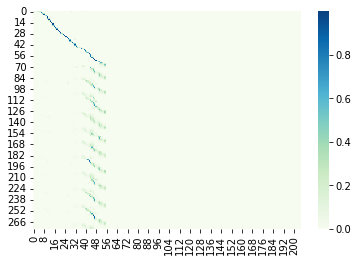


Epoch: 43/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND CISTOR INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VALMTEEARS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GO

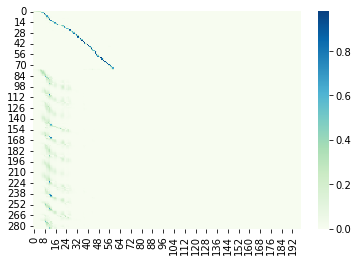


Epoch: 44/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEICLES BEGAN A RIVING FROM HARNESS FIRE TRUCKS THREE ABUALICES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROAD HOEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS OUR AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

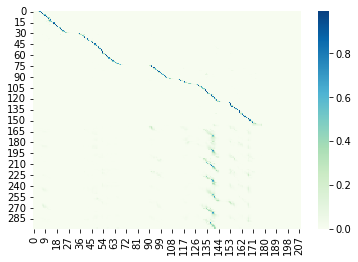


Epoch: 45/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROSER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF REFUGE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABUALANCES AND PRIVATE CARS DRIVEN BY VOLUME TEARS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTEL HOWEVER IS LESS DISTINCTIVELY GERMING AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HERRY THE LITTLE GIRLS GO

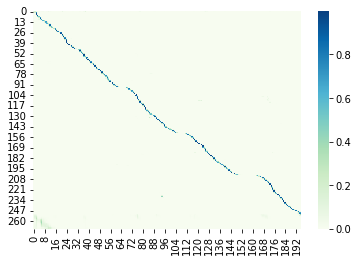


Epoch: 46/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHAL MINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUEVIOCALS BEGAN ARRIVING FROM HARNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEARS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOT BROAD HOWEVER IS LESS DISTINCTIVELY GERMING AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINT OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING F

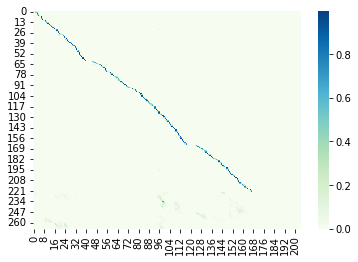

Save successful 45

Epoch: 47/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PRESER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUEVVIEW VEHICLES BEGAN AWRIVING FROM HARKNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBROAR HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIR

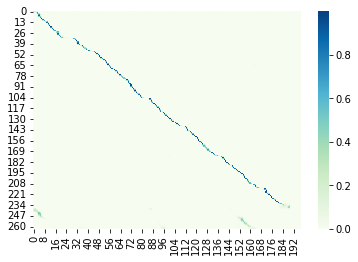


Epoch: 48/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCUE VEHICLES BEGAN AWRIVING FROM HARNESS FIRE TRUTS THREE ABUSES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING 

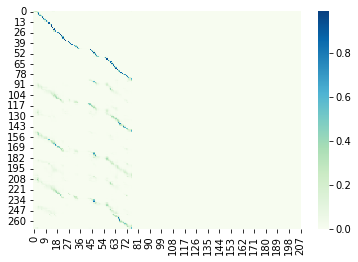


Epoch: 49/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RATCHY VEHICLES BEGAN AWRIVING FROM HARKNESS FIRE TRUCKS THREE ABUNCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTEL HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRIONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINT OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING FAM

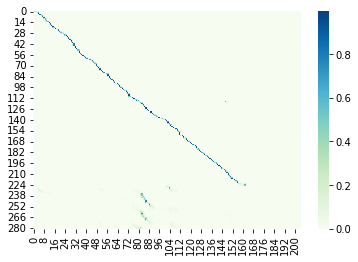


Epoch: 50/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUEVEICALS BEGAN A RIVING FROM HARNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRL'S 

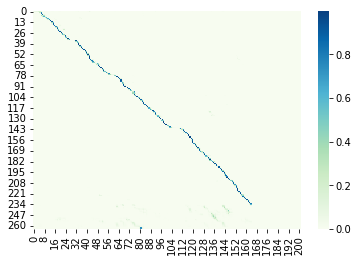


Epoch: 51/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RATCHY VEHICLES BEGAN AWRIVING FROM HARKNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBROUGH HOLEVER IS LESS DISTINCTIVELY GERMING AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS

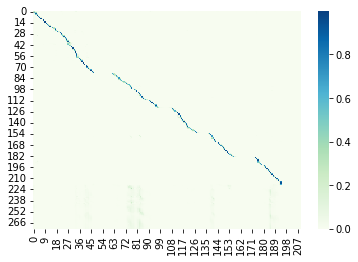

Save successful 50

Epoch: 52/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEAM OF RIVING FROM HARPNESS FIRE TRUCKS THREE ABUNCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTE BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS OUR AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING FAMOUSLY TO NIGHT IN CHEE


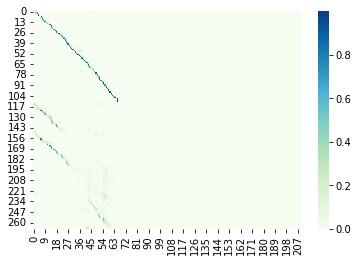


Epoch: 53/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF REFUGALS BEGAN AWRIVING FROM HARNESS FIRE TRUCKS THREE ABBUNCES AND PRIVATE CARS DRIVEN BY VOLENTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOPE BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMIN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING F

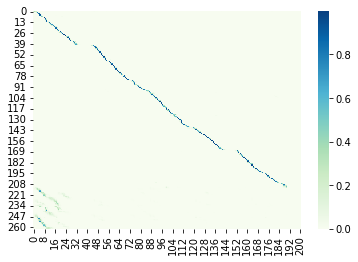


Epoch: 54/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROSER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RECHUVE VEHICLES BEGAN AWRIVING FROM HARNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMIN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAFE SIR HARRY THE LITTLE GIRL

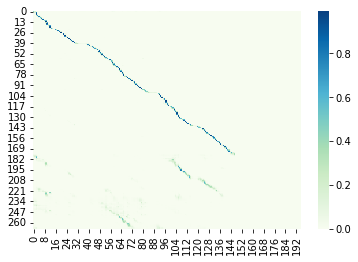


Epoch: 55/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROSERANT SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUEVVIECLES BEGAN AWRIVING FROM HARKNESS FIRE TRUCKS THREE ABBUNCS AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTEBROB HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING FA

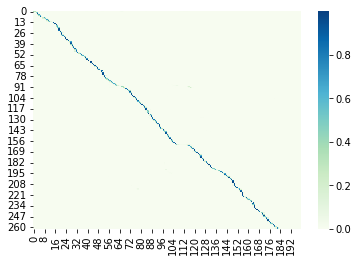


Epoch: 56/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROSSER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCUE VEHICLES BEGAN AWRIVING FROM HARKNESS FIRE TRUCKS THREE ABUALITANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAFE SIR HURRY THE LITTLE G

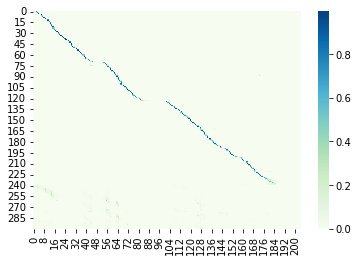

Save successful 55

Epoch: 57/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROVOUR AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RECKYUVEAGLES BEGAN AWRIVING FROM HARKNESS FIRE TRUCKS THREE ABBUILANCES AND PRIVATE CARS DRIVEN BY VOLENTEARS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HALF BROAD HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HERRY THE LITTLE GIRLS G

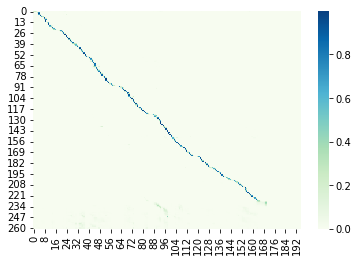


Epoch: 58/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABBELANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOPE BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMIN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAFE SIR HARRY THE LITTLE GIRL'S 

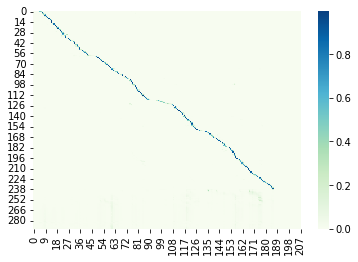


Epoch: 59/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RATHEW VEHICLES BEGAN AWRIVING FROM HARKNESS FIRE TRUCKS THREE ABUEENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTEL HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING 

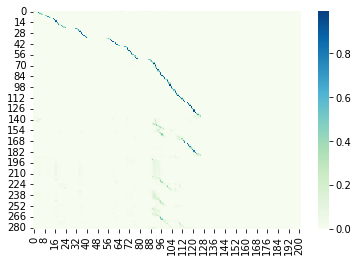


Epoch: 60/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VIAGOS BEGAN AWRIIVING FROM HARNTNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROAD HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRL'S 

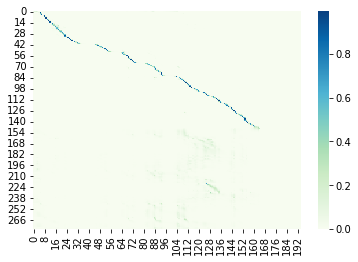


Epoch: 61/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHAL LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCAUVEYACLES BEGAN ARRIVING FROM HEARTNESS FIREDTRUCKS THREE ABUALANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOPE ROLL HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRL'S G

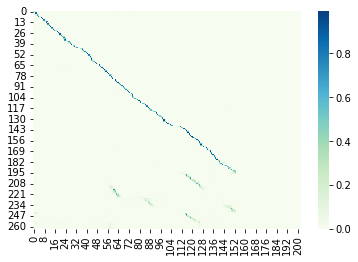

Save successful 60

Epoch: 62/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROUGHT HER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RECKY VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABUEUTSES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTE BROAD HOWEVER IS LESS DISTINCTIVELY GERMING AS THE GREATER NUMBER OF ITS PATRONS OUR AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HERRY THE LITTLE GIR

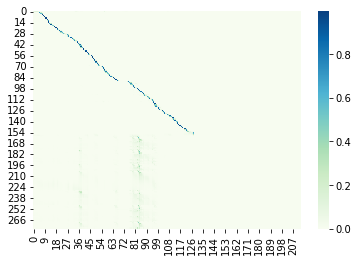


Epoch: 63/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE WINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCUE VEHICLES BEGAN AWRIVING FROM HARKNESS FIRE TRUCKS THREE ABUELANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMING AS THE GREATER NUMBER OF ITS PATRONS ARE AN ERROCONS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAFE SIR HARRY THE LITTLE 

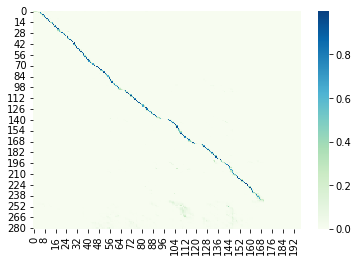


Epoch: 64/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN AWRIVING FROM HARKNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOT BROAD HOWEVER IS LESS DISTINCTIVELY GERMING AS THE GREATER NUMBER OF ITS PATRIONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAFE SIR HARRY THE LITTLE GIRL'

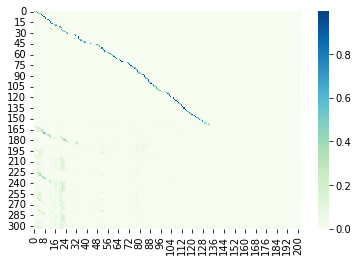


Epoch: 65/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VIAGOS BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS 

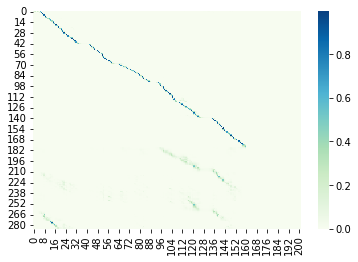


Epoch: 66/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABUEUENCES AND PRIVATE CARS DRIVEN BY VOLUME TEARS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF IT PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAFE SIR HARRY THE LITTLE GI

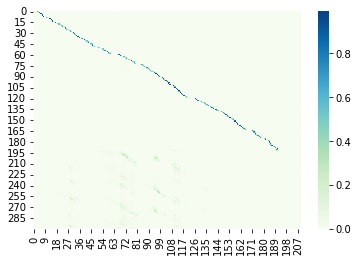

Save successful 65

Epoch: 67/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROSER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABUALANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAOG HOWEVER IS LESS DISTINCTIVELY GERMING AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

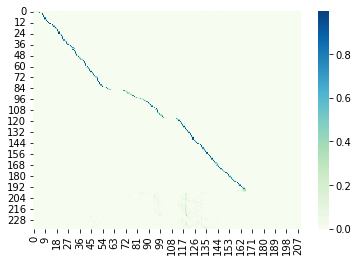


Epoch: 68/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCUE VIAGOES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABUEENCES AND PRIVATE CARS DRIVEN BY VOLENT YEARS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROW HOWEVER IS LESS DISTINCTIVELY GERMING AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GO

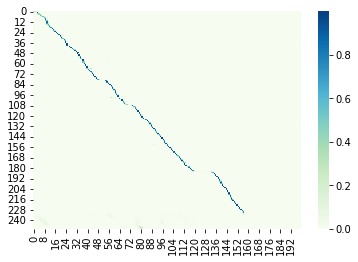


Epoch: 69/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RECKY VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABUELANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROAHHOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAFE SIR HARRY THE LITTLE GIRLS G

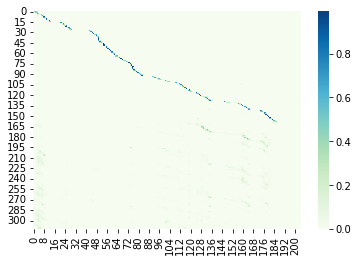


Epoch: 70/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABUELANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROAHHOWEVER IS LESS DISTINCTIVELY JERMING AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS 

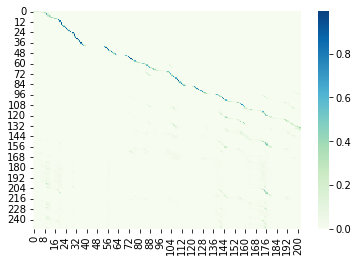


Epoch: 71/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND CISTER INDEATH THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABUENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS G

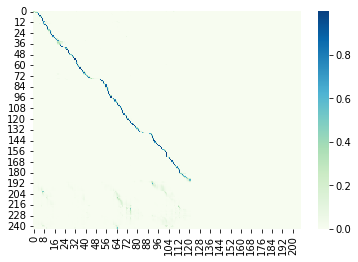

Save successful 70

Epoch: 72/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCAUVEIAGO BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLT BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAS SAID SIR HARRY THE LITTLE GIRLS GO

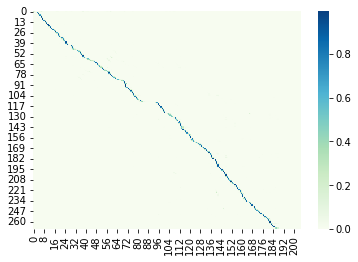


Epoch: 73/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND CISTORK INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPH ONLY IN WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HALF BROAK HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS 

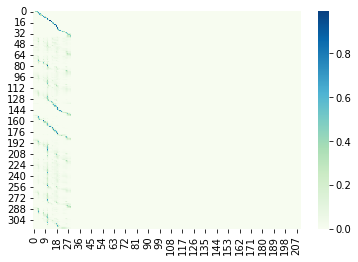


Epoch: 74/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PRETHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RAFU VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABUELANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HALF BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

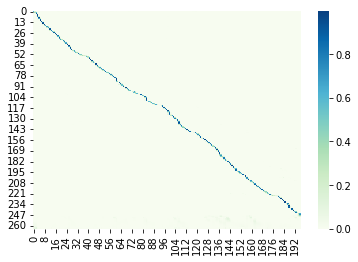


Epoch: 75/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABBELANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRIB HOWEVER IS LESS DISTINCTIVELY GERMING AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SAID HER HARRY THE LITTLE GI

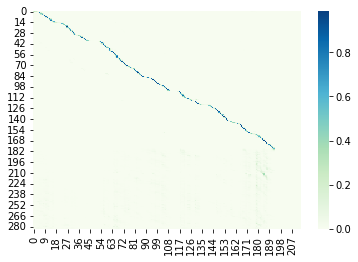


Epoch: 76/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCULAR VEHICLES BEGAN ARRIVING FROM HEARTNESS FIRE TRUCKS THREE ABUENCES AND PRIVATE CARS DRIVEN BY VOLLENT TEARS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROAHHOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIR

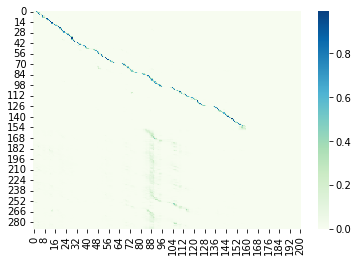

Save successful 75

Epoch: 77/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABUENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOAF BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HERRY THE LITTLE GIRLS 

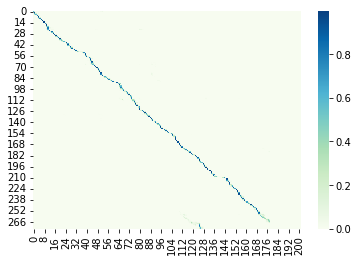


Epoch: 78/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULOCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HULT BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOIN

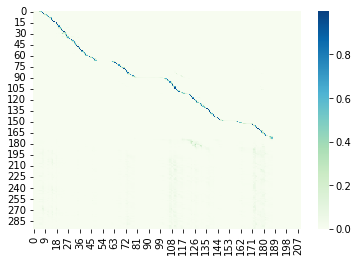


Epoch: 79/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN A RIVING FROM HARKNESS FIRE TRUNKS THREE ABUNCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING 

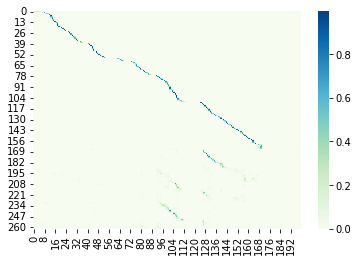


Epoch: 80/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN A RIVING FROM HARKNESS FIRE TRUCKS THREE ABBELANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRL'S 

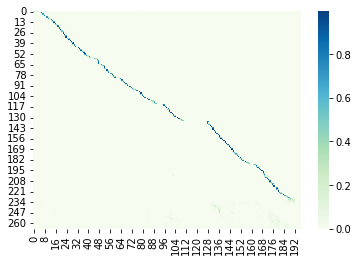


Epoch: 81/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RECULARLES BEGAN ARRIVING FROM HEARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOT BROAD HOWEVER IS LESS DISTINCTIVELY GERMIN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING FA

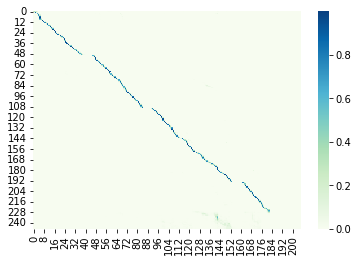

Save successful 80

Epoch: 82/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RECULARLES BEGAN ARRIVING FROM HARPNESS FIRE TRUCKS THREE ABUENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROADHHOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING FAM

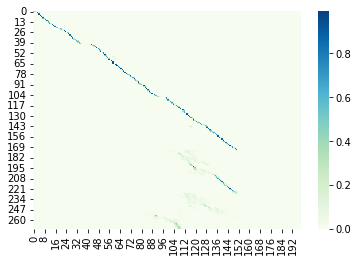


Epoch: 83/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABBELANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS G

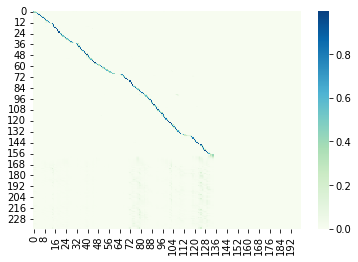


Epoch: 84/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND CISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABBIOANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAFE SIR HARRY THE LITTLE GIRLS 

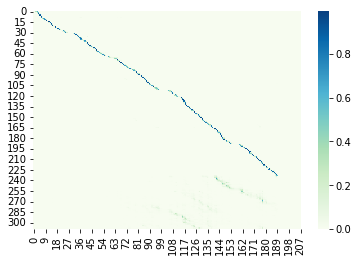


Epoch: 85/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOPE ROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POOING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HERRY THE LITTLE GIRLS GOIN

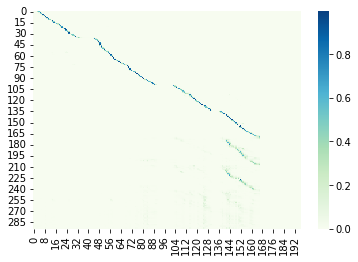


Epoch: 86/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AN A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TREACHED THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAA HOWEVER IS LESS DISTINCTIVELY GERMING AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS G

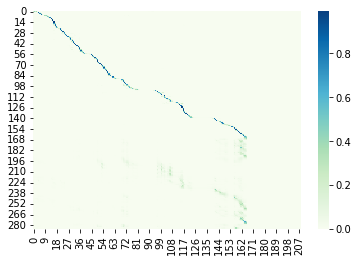

Save successful 85

Epoch: 87/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF REFUGAL VEHICLES BEGAN AWRIVING FROM HARKNESS FIRE TRUCKS THREE ABUNCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOT BROAD HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AN ERRORCANCE
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACED POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS

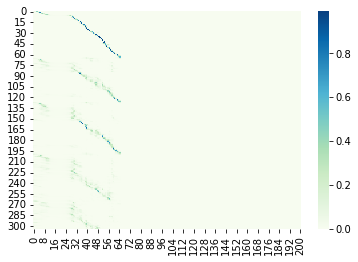


Epoch: 88/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN PROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN AWRIVING FROM HARKNESS FIRE TRUCKS THREE ABBELANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROAD HOWEVER IS LESS DISTINCTIVELY GERMIN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POINT OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GO

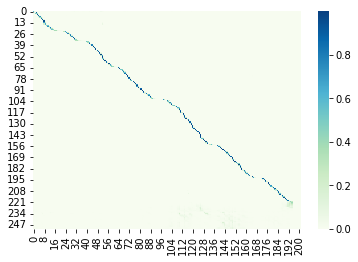


Epoch: 89/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAFE SIR HARRY THE LITTLE GIRLS G

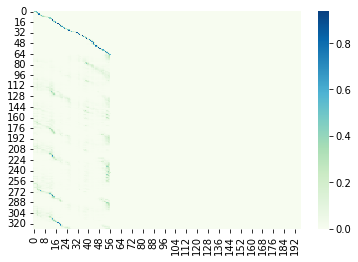

Epoch    89: reducing learning rate of group 0 to 5.0000e-04.

Epoch: 90/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABBELANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROAD HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS 

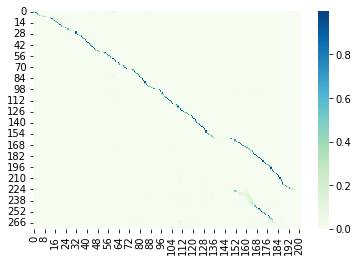


Epoch: 91/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABBELLANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOPE BROAB HOWEVER IS LESS DISTINCTIVELY GERMING AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRL

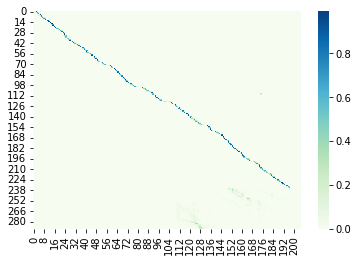

Save successful 90

Epoch: 92/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOP BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACED POINTING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAFE SIR HARRY THE LITTLE GIRLS 

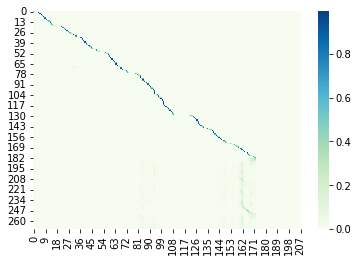


Epoch: 93/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOP BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOIN

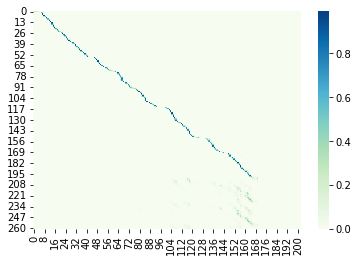


Epoch: 94/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABUEENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROAD HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAFE SIR HARRY THE LITTLE GIRLS G

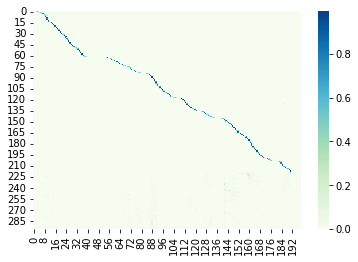


Epoch: 95/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE IMMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAFE SIR HARRY THE LITTLE GIRLS G

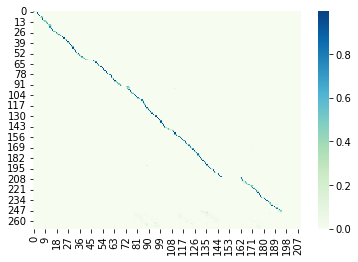


Epoch: 96/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROAD HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GO

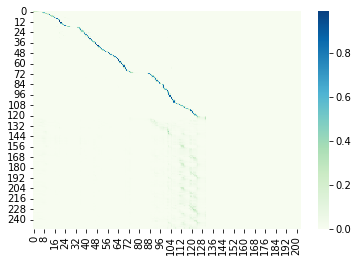

Save successful 95

Epoch: 97/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RAFCUL VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROAHHOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GO

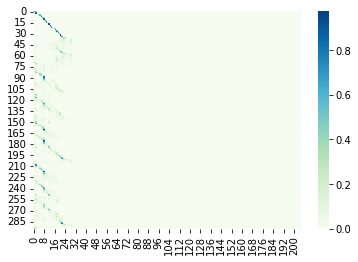


Epoch: 98/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RECUICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOPE ROAR HOWEVER HIS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING FA

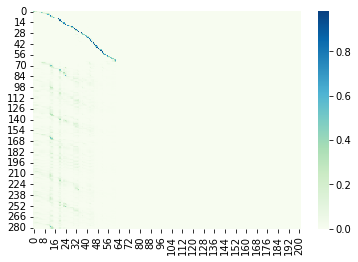


Epoch: 99/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RECULL VEHICLES BEGAN AWRIVING FROM HARKNESS FIRE TRUCKS THREE ABUEENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROAD HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GO

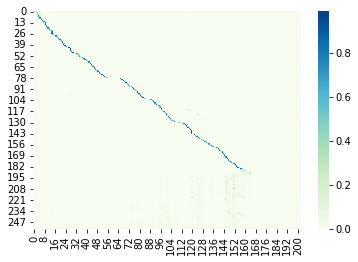


Epoch: 100/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN AWRIVING FROM HARKNESS FIRE TRUCKS THREE ABBELANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOPEROR HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUIING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

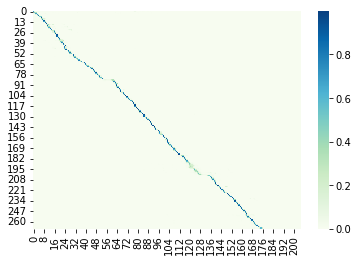


Epoch: 101/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCATE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRETRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOPHORRA HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUIING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

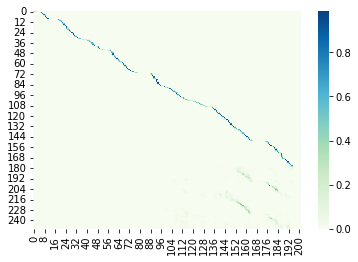

Save successful 100
Epoch   101: reducing learning rate of group 0 to 2.5000e-04.

Epoch: 102/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCAUVEICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUME TEARS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAL HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOIN

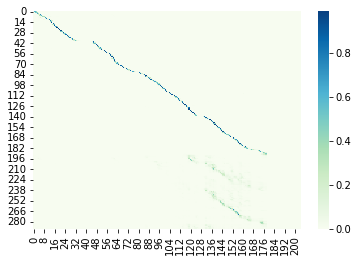


Epoch: 103/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOP BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS G

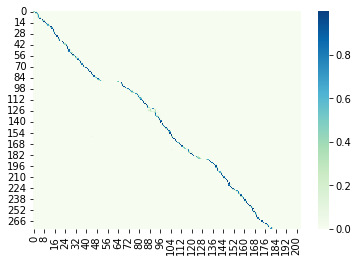


Epoch: 104/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAL HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOIN

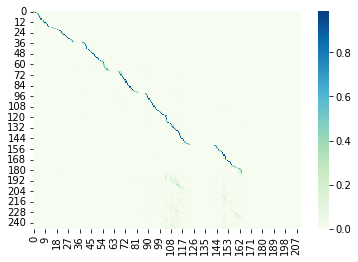


Epoch: 105/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAA HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOIN

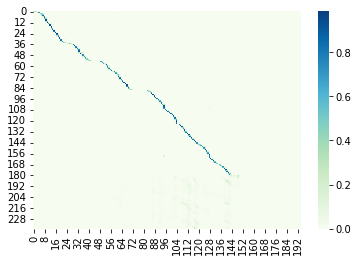


Epoch: 106/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOP BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS G

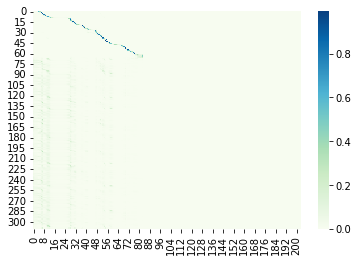

Save successful 105

Epoch: 107/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND CISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLVINTEARS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROAH HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS G

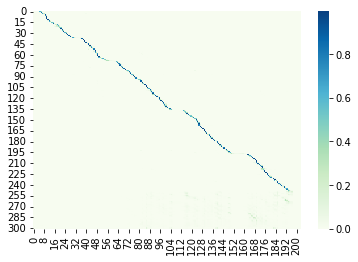


Epoch: 108/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN AWRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROAHHOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

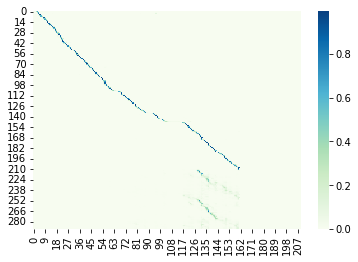


Epoch: 109/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOP BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS G

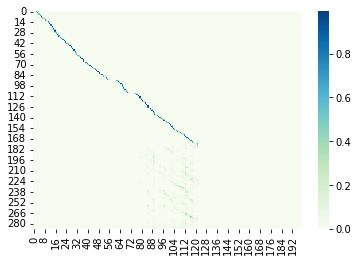


Epoch: 110/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOPEROR HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOIN

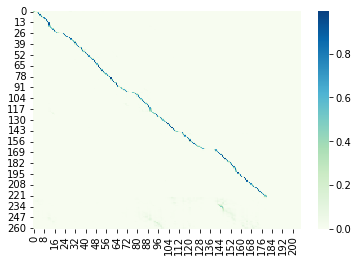


Epoch: 111/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAL HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

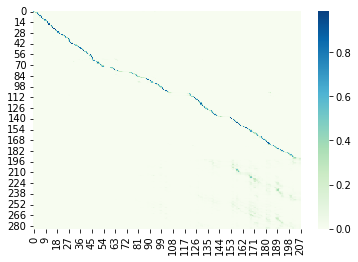

Save successful 110

Epoch: 112/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLVINTEARS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAL HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GO

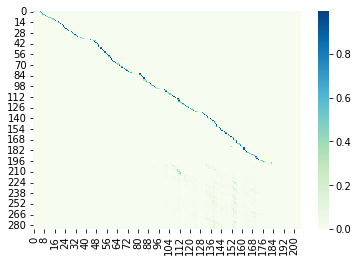


Epoch: 113/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAA HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

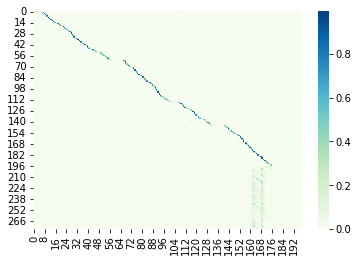


Epoch: 114/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN AWRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOIN

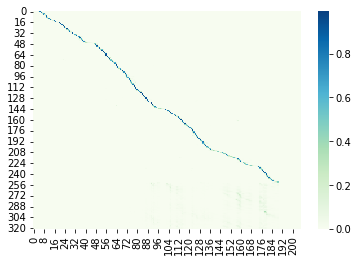


Epoch: 115/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RECULARS BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING FAMO

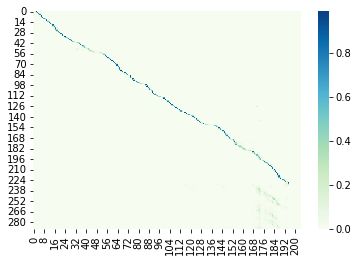


Epoch: 116/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOP BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS 

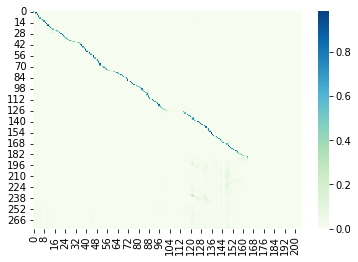

Save successful 115

Epoch: 117/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF REFUGE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

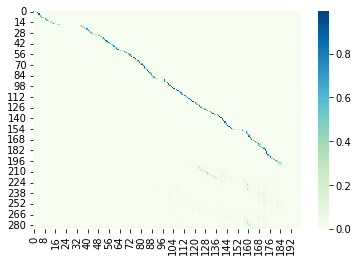

Epoch   117: reducing learning rate of group 0 to 1.2500e-04.

Epoch: 118/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GO

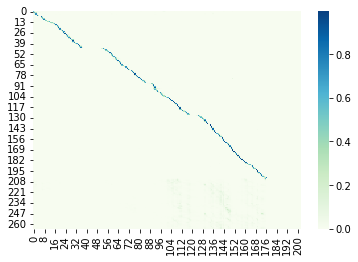


Epoch: 119/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAA HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

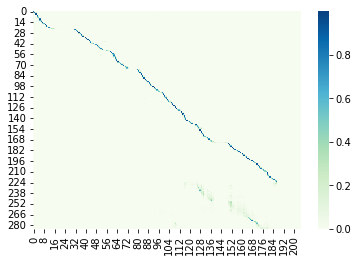


Epoch: 120/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

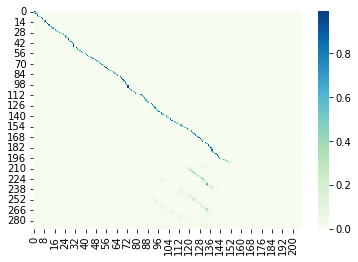


Epoch: 121/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCAUVEICLES BEGAN ARRIVING FROM HARKNESS FIRETRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAL HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUIING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING 

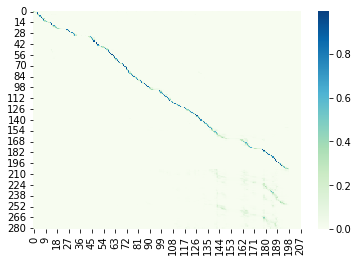

Save successful 120

Epoch: 122/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

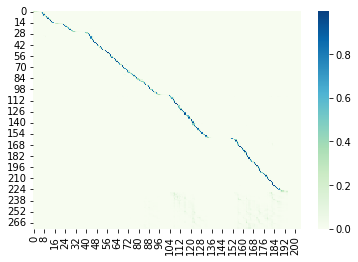


Epoch: 123/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND CISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCAUVEICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRABL HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOIN

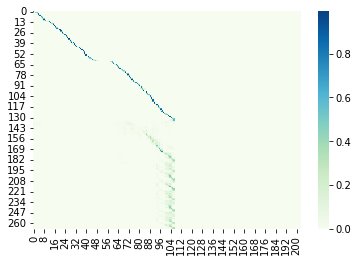


Epoch: 124/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCAUVIACOS BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING

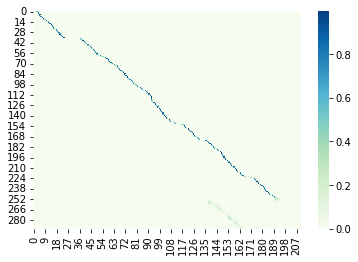


Epoch: 125/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

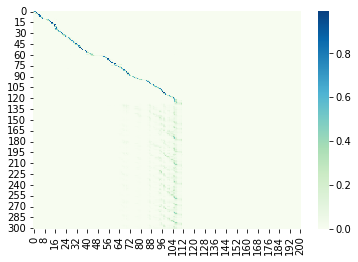


Epoch: 126/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCAUVEICLS BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POUING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAFE SIR HARRY THE LITTLE GIRLS GOING 

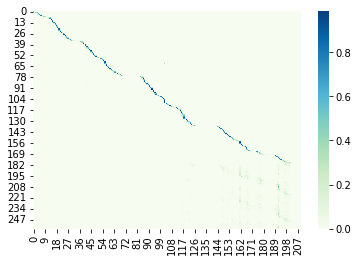

Save successful 125

Epoch: 127/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAL HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

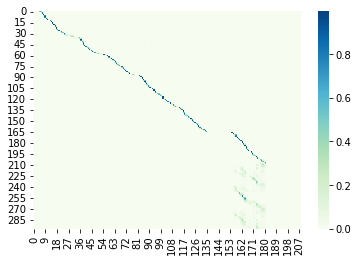


Epoch: 128/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCAUVEIGLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOPROO HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING F

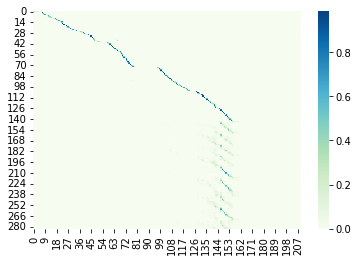


Epoch: 129/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRETRUCKS THREE ABULENCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOIN

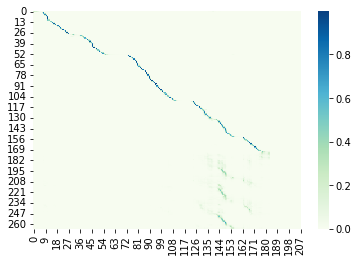


Epoch: 130/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCAUVEICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOLF BROW HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOIN

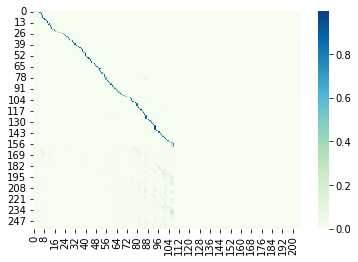

Epoch   130: reducing learning rate of group 0 to 6.2500e-05.

Epoch: 131/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAL HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

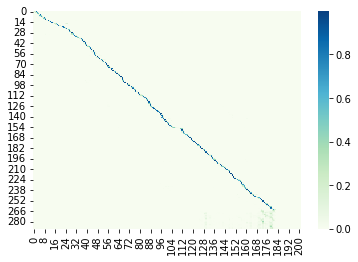

Save successful 130

Epoch: 132/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUME TEARS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS G

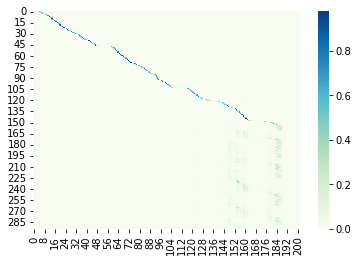


Epoch: 133/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAL HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

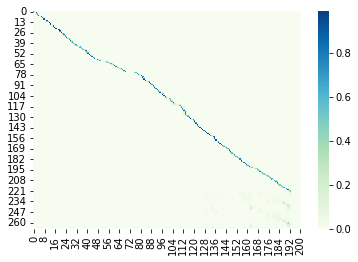


Epoch: 134/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOPEROR HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOIN

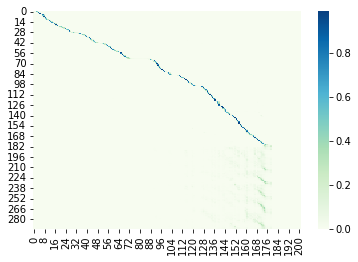


Epoch: 135/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRETRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUME TEARS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOPE OOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING 

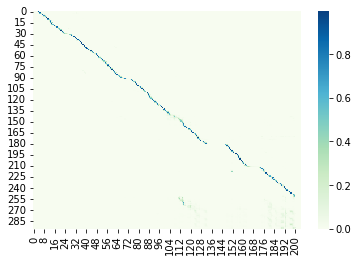


Epoch: 136/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAA HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

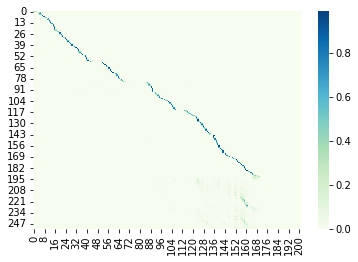

Save successful 135

Epoch: 137/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

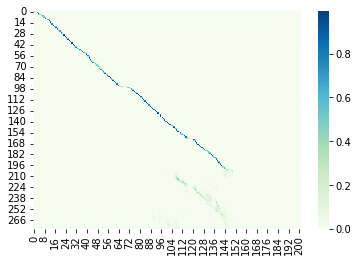


Epoch: 138/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOPEROR HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOIN

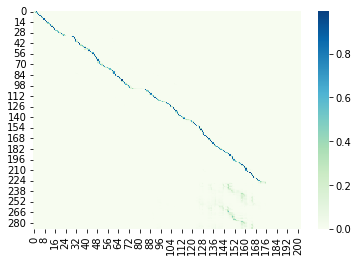


Epoch: 139/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

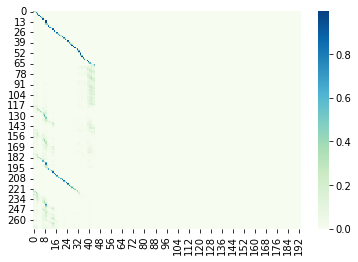


Epoch: 140/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRETRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOIN

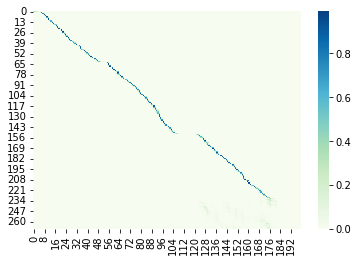


Epoch: 141/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRETRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOIN

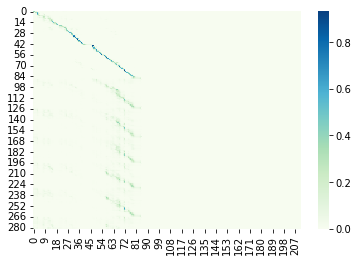

Save successful 140

Epoch: 142/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAA HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

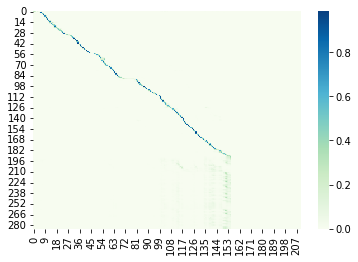


Epoch: 143/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOP BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAFE SIR HARRY THE LITTLE GIRLS

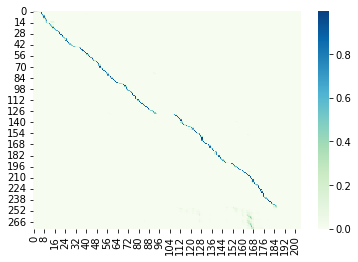


Epoch: 144/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOPROO HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING

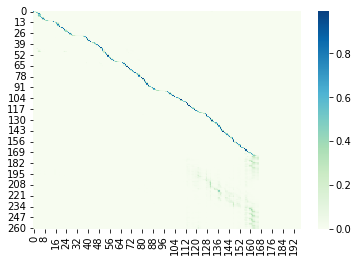


Epoch: 145/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND CISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

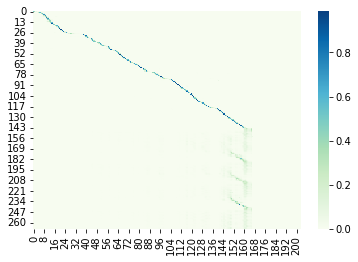


Epoch: 146/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOP ROOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING F

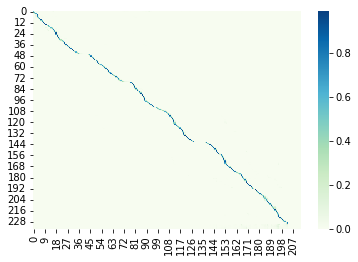

Save successful 145

Epoch: 147/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

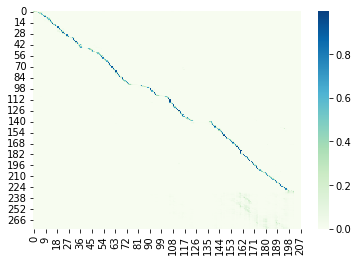


Epoch: 148/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

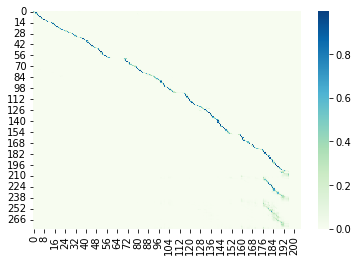


Epoch: 149/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

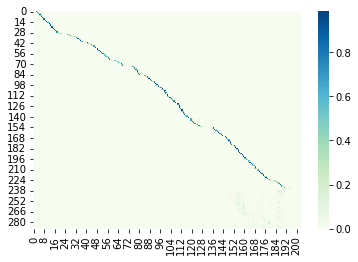


Epoch: 150/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

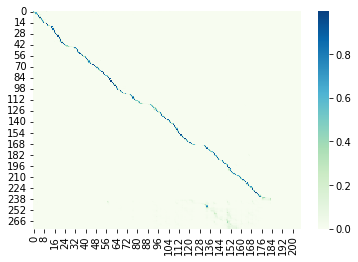


Epoch: 151/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AN AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAFE SIR HARRY THE LITTLE GIRLS

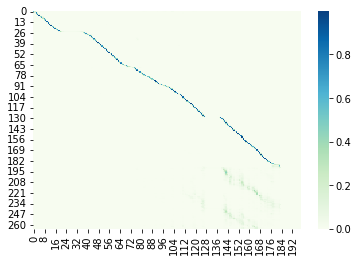

Save successful 150

Epoch: 152/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

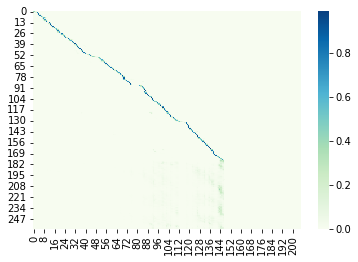


Epoch: 153/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUME TEARS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAB HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS OUR AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS G

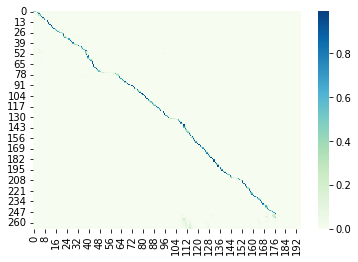


Epoch: 154/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUME TEARS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAB HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS G

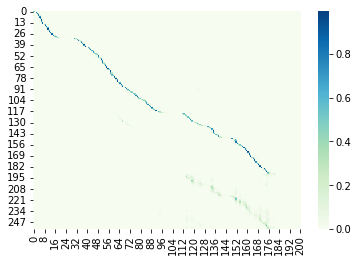


Epoch: 155/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

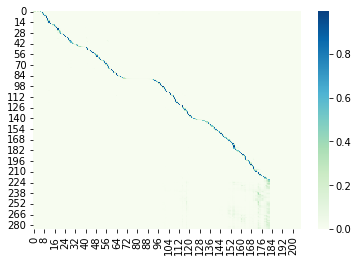


Epoch: 156/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOP BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS 

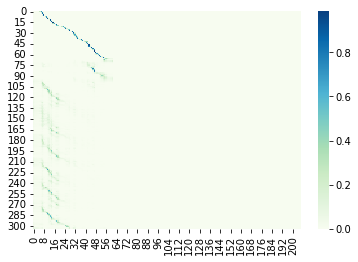

Save successful 155
Epoch   156: reducing learning rate of group 0 to 3.1250e-05.

Epoch: 157/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RASCAUVEIGHBLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

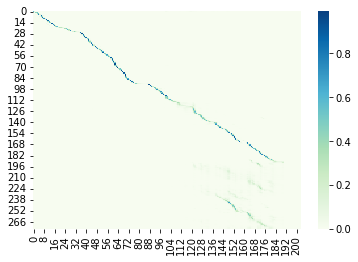


Epoch: 158/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOP BROUGH HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS G

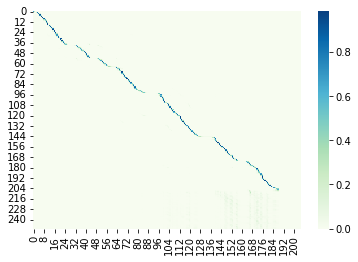


Epoch: 159/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAFE SIR HARRY THE LITTLE GIRLS GO

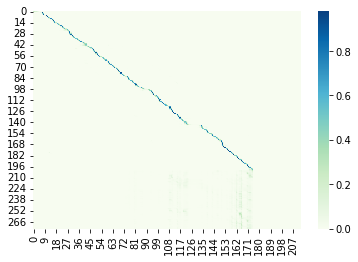


Epoch: 160/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN AWRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOP BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS 

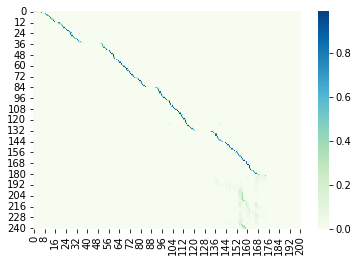


Epoch: 161/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOP BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS 

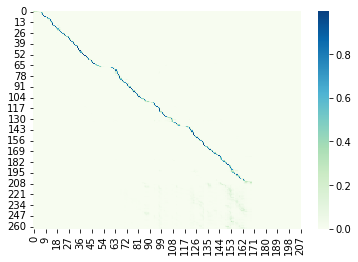

Save successful 160

Epoch: 162/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOP BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS 

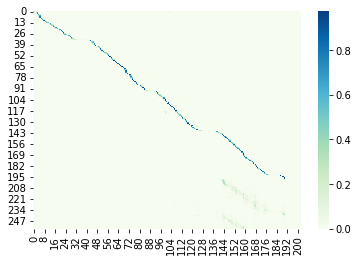


Epoch: 163/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOP BROUGHT HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS 

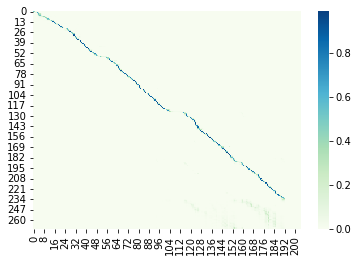


Epoch: 164/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

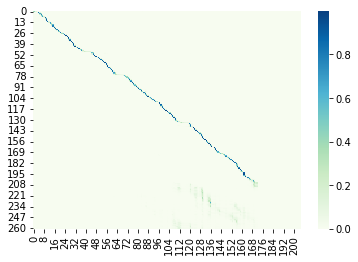


Epoch: 165/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

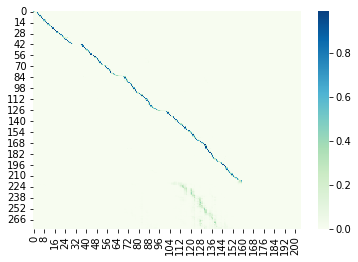


Epoch: 166/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

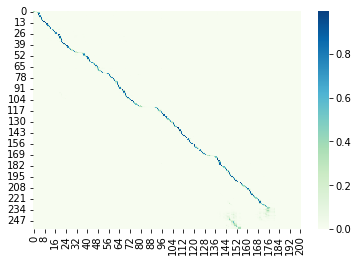

Save successful 165

Epoch: 167/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOPROO HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOING

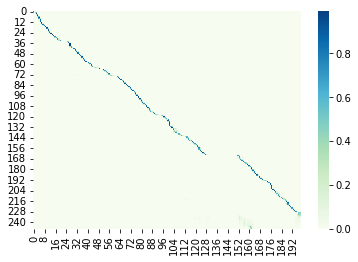

Epoch   167: reducing learning rate of group 0 to 1.5625e-05.

Epoch: 168/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

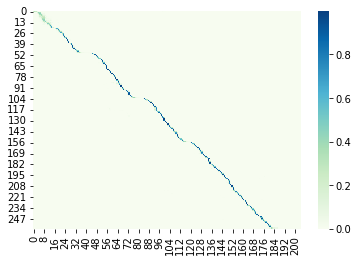


Epoch: 169/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

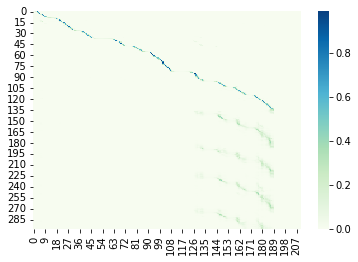


Epoch: 170/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

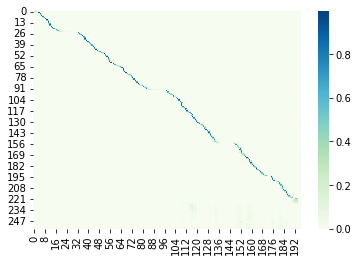


Epoch: 171/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

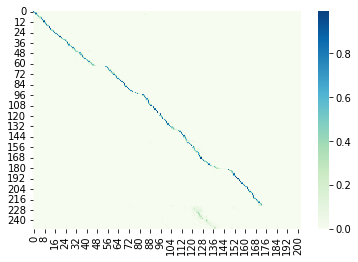

Save successful 170

Epoch: 172/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

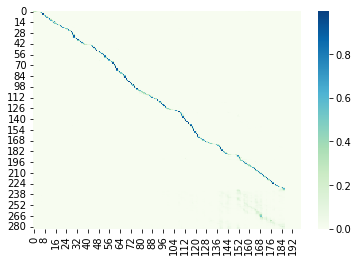


Epoch: 173/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

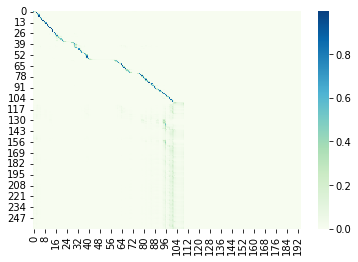


Epoch: 174/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

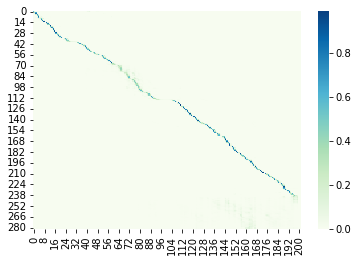


Epoch: 175/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

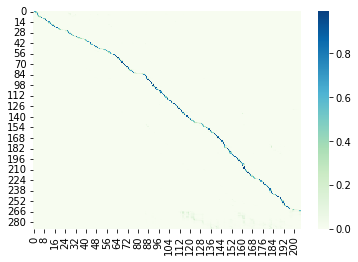


Epoch: 176/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

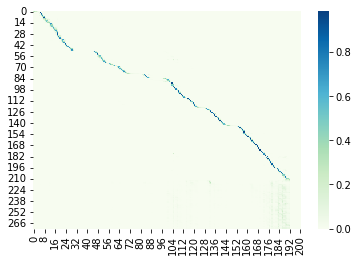

Save successful 175

Epoch: 177/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

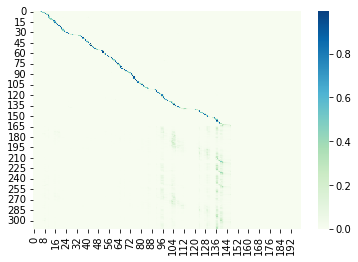


Epoch: 178/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

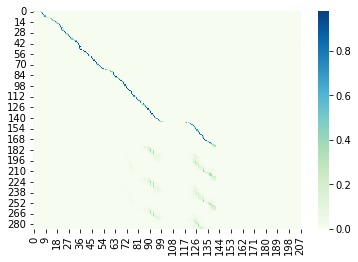

Epoch   178: reducing learning rate of group 0 to 7.8125e-06.

Epoch: 179/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

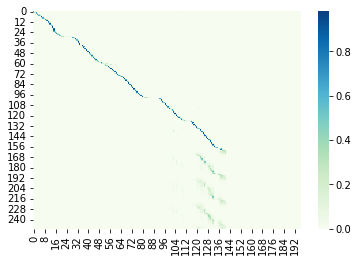


Epoch: 180/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

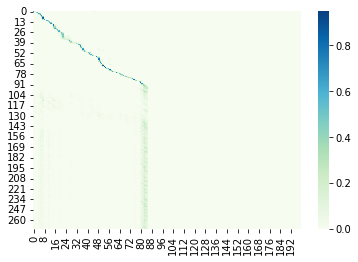


Epoch: 181/200


Train:   0%|          | 0/298 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [46]:
best_lev_dist = float("inf")
tf_rate = 1.0

for epoch in range(0, config['epochs']):
    
    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))

    # Call train and validate 
    running_loss, running_perplexity, attention_plot = train(model, train_loader, criterion, optimizer, tf_rate, aug_data=(best_lev_dist < 14))
    valid_dist = validate(model, val_loader)

    # Print your metrics
    print("Levenshtein Distance", valid_dist)

    # Plot Attention 
    plot_attention(attention_plot)

    # Log metrics to Wandb
        ### Log metrics at each epoch in your run - Optionally, you can log at each batch inside train/eval functions (explore wandb documentation/wandb recitation)
    wandb.log({"train loss": running_loss, "validation distance": valid_dist, "tf rate": tf_rate})

    ### Save checkpoint if accuracy is better than your current best
    if valid_dist <= best_lev_dist:

      ### Save checkpoint with information you want
      torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': running_loss,
              'valid_dist': valid_dist}, 
        './model_checkpoint.pth')
      
      ### Save checkpoint in wandb
      wandb.save('model_checkpoint.pth')
    if epoch % 5 == 0:
      try:
        torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': running_loss,
              'valid_dist': valid_dist}, run_name + "_" + str(epoch))

        print("Save successful "+str(epoch))
      except:
        print("Save unsuccessful")

    # Optional: Scheduler Step / Teacher Force Schedule Step
    scheduler.step(valid_dist)

    if valid_dist < 21:
      tf_rate = 0.99*tf_rate

    if valid_dist <= best_lev_dist:
        best_lev_dist = valid_dist
        # Save your model checkpoint here

Second stage training (Not used in final submission)

In [ ]:
# model = loaded_model

In [ ]:
# optimizer   = torch.optim.Adam(model.parameters(), lr= config['lr'], amsgrad= True, weight_decay= 5e-6)
# # optimizer.load_state_dict(sm_dict['optimizer_state_dict'])
# criterion   = torch.nn.CrossEntropyLoss(reduction='none') # Why are we using reduction = 'none' ? 
# scaler      = torch.cuda.amp.GradScaler()
# scheduler   = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True, patience=5)

In [ ]:
# validate(model, val_loader)

In [ ]:
# best_lev_dist = float("inf")
# tf_rate = 0.6

# for epoch in range(100, config['epochs']):
    
#     print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))

#     # Call train and validate 
#     running_loss, running_perplexity, attention_plot = train(model, train_loader, criterion, optimizer, tf_rate, aug_data=True)
#     valid_dist = validate(model, val_loader)

#     # Print your metrics
#     print("Levenshtein Distance", valid_dist)

#     # Plot Attention 
#     plot_attention(attention_plot)

#     # Log metrics to Wandb
#         ### Log metrics at each epoch in your run - Optionally, you can log at each batch inside train/eval functions (explore wandb documentation/wandb recitation)
#     wandb.log({"train loss": running_loss, "validation distance": valid_dist}) #, "tf rate": tf_rate})

#     ### Save checkpoint if accuracy is better than your current best
#     if valid_dist <= best_lev_dist:

#       ### Save checkpoint with information you want
#       torch.save({'epoch': epoch,
#               'model_state_dict': model.state_dict(),
#               'optimizer_state_dict': optimizer.state_dict(),
#               'loss': running_loss,
#               'valid_dist': valid_dist}, 
#         './model_checkpoint.pth')
      
#       ### Save checkpoint in wandb
#       wandb.save('model_checkpoint.pth')
#     if epoch % 5 == 0:
#       try:
#         torch.save({'epoch': epoch,
#               'model_state_dict': model.state_dict(),
#               'optimizer_state_dict': optimizer.state_dict(),
#               'loss': running_loss,
#               'valid_dist': valid_dist}, run_name + "_" + str(epoch))

#         print("Save successful "+str(epoch))
#       except:
#         print("Save unsuccessful")

#     # Optional: Scheduler Step / Teacher Force Schedule Step
#     if epoch > 80:
#       scheduler.step(valid_dist)

#     # if epoch < len(tf_rate_scheduler):
#       # tf_rate = tf_rate_scheduler[epoch]
#     # else:
#       # tf_rate = 0

#     if valid_dist <= best_lev_dist:
#         best_lev_dist = valid_dist
#         # Save your model checkpoint here

In [58]:
run.finish()

# Testing

In [47]:
sm_dict = {'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': running_loss,
              'valid_dist': valid_dist}

In [48]:
# Optional: Load your best model Checkpoint here
sm_dict_loaded = torch.load("model_checkpoint.pth")
sm_dict['epoch'] = sm_dict_loaded['epoch']
sm_dict['model_state_dict'] = sm_dict_loaded['model_state_dict']
sm_dict['optimizer_state_dict'] = sm_dict_loaded['optimizer_state_dict']
sm_dict['loss'] = sm_dict_loaded['loss']
sm_dict['valid_dist'] = sm_dict_loaded['valid_dist']
print(sm_dict['valid_dist'])

7.348060344827585


In [49]:
input_size = 15
encoder_hidden_size = 512
vocab_size = len(VOCAB)
embed_size = 256
decoder_hidden_size = 512
decoder_output_size = 128
projection_size = 128

loaded_model = LAS(
    input_size, 
    encoder_hidden_size, 
    vocab_size, 
    embed_size,
    decoder_hidden_size, 
    decoder_output_size,
    projection_size
    # Initialize your model 
    # Read the paper and think about what dimensions should be used
    # You can experiment on these as well, but they are not requried for the early submission
    # Remember that if you are using weight tying, some sizes need to be the same
)

loaded_model = loaded_model.to(DEVICE)
loaded_state_dict = sm_dict['model_state_dict']

In [50]:
loaded_model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

In [51]:
validate(loaded_model, val_loader)

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Ground Truth :  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING
Prediction   :  IF WE HAD BEEN BROTHER AND CISTER INDEED THERE WAS NOTHING
Ground Truth :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE AMBULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Prediction   :  THE TELEPHONE LINE WAS SOON REPAIRED AND A STEADY STREAM OF RESCUE VEHICLES BEGAN ARRIVING FROM HARKNESS FIRE TRUCKS THREE ABULANCES AND PRIVATE CARS DRIVEN BY VOLUNTEERS
Ground Truth :  THE HOF BRAU HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Prediction   :  THE HOTHBRAP HOWEVER IS LESS DISTINCTIVELY GERMAN AS THE GREATER NUMBER OF ITS PATRONS ARE AMERICANS
Ground Truth :  HE GETS A RED FACE PORING OVER THEM
Prediction   :  HE GETS A RED FACE POURING OVER THEM
Ground Truth :  I SAY SIR HARRY THE LITTLE GIRL'S GOING FAMOUSLY TO NIGHT ISN'T SHE
Prediction   :  I SAY SIR HARRY THE LITTLE GIRLS GOI

7.348060344827585

In [52]:
def create_strings(predictions, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape
    strings = []

    for batch_idx in range(batch_size): 

        # y_sliced    = indices_to_chars(y[batch_idx,0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        # y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        strings.append(pred_string)

    if print_example: 
        # Print y_sliced and pred_sliced if you are using the toy dataset
        print("Prediction   : ", pred_string)
        
    return strings

In [53]:
# TODO: Create a testing function similar to validation 
# TODO: Create a file with all predictions 
# TODO: Submit to Kaggle

def test(model,dataloader):

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []
  
  for i, (x, lx) in enumerate(dataloader):

    x, lx = x.to(DEVICE), lx

    with torch.inference_mode():
        predictions, attentions = model(x, lx, y = None)

    greedy_predictions   =  torch.argmax(predictions, dim=-1)
    outputs = create_strings(greedy_predictions, print_example=True)
    # outputs = outputs.detach().cpu().numpy().tolist()
    test_results.extend(outputs)
    
    batch_bar.update()

    del x
      
  batch_bar.close()
  return test_results

In [54]:
test_results = test(loaded_model, test_loader)

Test:   0%|          | 0/28 [00:00<?, ?it/s]

Prediction   :  INQUIRED RABBIN WITH HIS SUSPICION STILL UPON HIM
Prediction   :  AT LAST HE CAME OUT OF THEM AND WIPED HIS FACE AVED HEROUSLY
Prediction   :  THE WEATHER IF WE MAY USE THE TERM WILL CHANGE BEFORE LAW
Prediction   :  HOW KIND MAN USE AFTER ALL
Prediction   :  ON SATURDAY MORNINGS WHEN THE SODALITY MET IN THE CHAPEL TO RECITE THE LITTLE OFFICE HIS PLACE WAS A CUSHIONED KNEELING DESK AT THE RIGHT OF THE ALTAR FROM WHICH HE LED HIS WING OF BOYS THROUGH THE RESPONSES
Prediction   :  SEE THAT YOUR LIES BE A NOTHING WORSE THAN A BOYS CLIMBING FOR HIS ENTANGLED KIGHT
Prediction   :  DEA ME ONA CHATTA BOX REGETTING TO BE YNK REMOK TO MAGICIAN WHO WAS PLEASED WITH THE COMPLIMENT
Prediction   :  HOLLONG WITH A TAKEN TO DO THAT USING EVERY POSSIBLE CONTRACTION A QUARTER OF AN HOUR AND UNLESS
Prediction   :  HER REGARD SHIFTED TO THE GREEN STOCKS AND LEAVES AGAIN AND SHE STARTED TO MOVE AWAY
Prediction   :  I HAD A COMMON PATIENCE WITH YOU
Prediction   :  THE CLOSSETTINE SUPERVILLI

In [56]:
with open("submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_data)):
        f.write("{},{}\n".format(i, test_results[i]))

In [57]:
!kaggle competitions submit -c 11-785-f22-hw4p2 -f submission.csv -m "Final"

100% 289k/289k [00:00<00:00, 522kB/s]
Successfully submitted to Attention-Based Speech Recognition